**Segmentasi Harga Komoditas Pangan di Pulau Sumatera Tahun 2024 Menggunakan Gaussian Mixture Model Berbasis Algoritma Expectation-Maximization**

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Statistical analysis
from scipy.stats import linregress
from scipy.stats import multivariate_normal

# Machine Learning
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse

# Warnings (opsional, untuk suppress warning)
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

**IMPORT DATA**

In [2]:
# Load data dari Excel
df = pd.read_excel("Pulau Sumatera.xlsx")

# Tampilkan info dasar
print("="*60)
print("DATA OVERVIEW")
print("="*60)
print(f"\n📊 Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\n📋 Columns: {list(df.columns)}")
print(f"\n🔢 Data types:\n{df.dtypes}")

# Tampilkan 5 baris pertama
print("\n" + "="*60)
print("FIRST 5 ROWS")
print("="*60)
print(df.head())

# Info lebih detail
print("\n" + "="*60)
print("DATA INFO")
print("="*60)
df.info()

DATA OVERVIEW

📊 Shape: 27720 rows × 7 columns

📋 Columns: ['KabKot', 'Tahun', 'Bulan', 'Produk', 'Harga', 'Kategori', 'NamaProv']

🔢 Data types:
KabKot       object
Tahun         int64
Bulan        object
Produk       object
Harga       float64
Kategori     object
NamaProv     object
dtype: object

FIRST 5 ROWS
        KabKot  Tahun    Bulan                  Produk    Harga Kategori  \
0   Aceh Barat   2024  Januari           Beras Premium  14655.0    Beras   
1   Aceh Barat   2024  Januari            Beras Medium  12811.0    Beras   
2   Aceh Barat   2024  Januari            Bawang Merah  38386.0   Bawang   
3   Aceh Barat   2024  Januari  Bawang Putih (Bonggol)  41636.0   Bawang   
4   Aceh Barat   2024  Januari    Cabai Merah Keriting  38523.0    Cabai   

  NamaProv  
0     Aceh  
1     Aceh  
2     Aceh  
3     Aceh  
4     Aceh  

DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27720 entries, 0 to 27719
Data columns (total 7 columns):
 #   Column    Non-Null Count  D

Dataset ini berisi 27.720 observasi harga komoditas pangan yang dikumpulkan dari 154 kabupaten/kota di 10 provinsi Sumatera selama periode Januari-Desember 2024, mencakup 15 jenis produk pangan.

Dataset memiliki 7 variabel: 4 variabel kategorikal (KabKot, Bulan, Produk, NamaProv), 1 variabel numerik kontinu (Harga), 1 variabel numerik diskrit (Tahun), dan 1 variabel pengelompokan (Kategori).

Dari sample 5 baris pertama, terlihat data terstruktur dengan baik. Setiap baris merepresentasikan harga satu komoditas di satu kabupaten pada bulan tertentu. Terlihat variasi harga yang signifikan antar produk (dari Rp 12.811 untuk Beras Medium hingga Rp 41.636 untuk Bawang Putih)

**EKSPLORASI DATA**

In [3]:
print("="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

# 1. Unique values
print("\n1️⃣ UNIQUE VALUES PER COLUMN:")
print(f"   Kabupaten/Kota: {df['KabKot'].nunique()} unique")
print(f"   Provinsi: {df['NamaProv'].nunique()} unique")
print(f"   Produk: {df['Produk'].nunique()} unique")
print(f"   Tahun: {df['Tahun'].unique()}")
print(f"   Bulan: {df['Bulan'].nunique()} unique")

# 2. List produk
print("\n2️⃣ DAFTAR PRODUK:")
for i, produk in enumerate(df['Produk'].unique(), 1):
    count = (df['Produk'] == produk).sum()
    print(f"   {i}. {produk:30s} → {count:5d} records")

# 3. Missing values
print("\n3️⃣ MISSING VALUES:")
missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Missing_Percentage': missing_pct.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(missing_df.to_string(index=False))

# 4. Statistik harga
print("\n4️⃣ STATISTIK HARGA:")
print(df['Harga'].describe())

# 5. Cek data dengan format scientific notation (outlier)
scientific_mask = df['Harga'].astype(str).str.contains('E', case=False, na=False)
if scientific_mask.any():
    print(f"\n⚠️ WARNING: Ditemukan {scientific_mask.sum()} data dengan format scientific notation!")
    print("Sample data:")
    print(df[scientific_mask][['KabKot', 'Produk', 'Harga']].head())

EXPLORATORY DATA ANALYSIS

1️⃣ UNIQUE VALUES PER COLUMN:
   Kabupaten/Kota: 154 unique
   Provinsi: 10 unique
   Produk: 15 unique
   Tahun: [2024]
   Bulan: 12 unique

2️⃣ DAFTAR PRODUK:
   1. Beras Premium                  →  1848 records
   2. Beras Medium                   →  1848 records
   3. Bawang Merah                   →  1848 records
   4. Bawang Putih (Bonggol)         →  1848 records
   5. Cabai Merah Keriting           →  1848 records
   6. Cabai Rawit Merah              →  1848 records
   7. Daging Sapi Murni              →  1848 records
   8. Daging Ayam Ras                →  1848 records
   9. Telur Ayam Ras                 →  1848 records
   10. Gula Konsumsi                  →  1848 records
   11. Minyak Goreng Kemasan          →  1848 records
   12. Minyak Goreng Curah            →  1848 records
   13. Jagung Tk. Peternak            →  1848 records
   14. Cabai Merah Besar              →  1848 records
   15. Minyakita                      →  1848 records

3️⃣ MISSIN

Dataset mencakup 15 komoditas pangan strategis yang terbagi dalam 7 kategori utama: Beras (2 jenis), Bawang (2 jenis), Cabai (3 jenis), Protein Hewani (3 jenis), Gula (1 jenis), Minyak Goreng (3 jenis), dan Jagung (1 jenis). Semua produk memiliki 1.848 observasi yang terdistribusi merata.

6.012 dari 27.720 = 21.69% data harga hilang.

**DATA CLEANING**

In [4]:
print("="*60)
print("DATA CLEANING: REMOVE PRODUCTS WITH >50% MISSING")
print("="*60)

# Threshold missing value
threshold = 0.50  # 50%

# Hitung missing per produk
missing_per_product = df.groupby('Produk')['Harga'].apply(
    lambda x: x.isnull().sum() / len(x)
)

print("\n📊 MISSING VALUES PER PRODUCT:")
missing_per_product_df = missing_per_product.sort_values(ascending=False).reset_index()
missing_per_product_df.columns = ['Produk', 'Missing_Percentage']
missing_per_product_df['Missing_Percentage'] = missing_per_product_df['Missing_Percentage'] * 100
print(missing_per_product_df.to_string(index=False))

# Identifikasi produk yang harus dihapus
products_to_remove = missing_per_product[missing_per_product > threshold].index.tolist()

print(f"\n❌ PRODUK YANG AKAN DIHAPUS (>{threshold*100}% missing):")
if products_to_remove:
    for i, prod in enumerate(products_to_remove, 1):
        pct = missing_per_product[prod] * 100
        print(f"   {i}. {prod:30s} → {pct:.1f}% missing")
else:
    print("   ✅ Tidak ada produk dengan missing >50%")

# Hapus produk
df_clean = df[~df['Produk'].isin(products_to_remove)].copy()

print(f"\n📉 Shape sebelum: {df.shape}")
print(f"📈 Shape setelah:  {df_clean.shape}")
print(f"🗑️  Data terhapus:  {df.shape[0] - df_clean.shape[0]} rows")

# Update list produk
print(f"\n✅ Produk tersisa: {df_clean['Produk'].nunique()} produk")
print(df_clean['Produk'].unique())

DATA CLEANING: REMOVE PRODUCTS WITH >50% MISSING

📊 MISSING VALUES PER PRODUCT:
                Produk  Missing_Percentage
     Cabai Merah Besar          100.000000
             Minyakita          100.000000
   Jagung Tk. Peternak           68.398268
     Cabai Rawit Merah           39.393939
   Minyak Goreng Curah            8.333333
     Daging Sapi Murni            7.413420
 Minyak Goreng Kemasan            1.406926
          Beras Medium            0.378788
         Beras Premium            0.000000
          Bawang Merah            0.000000
Bawang Putih (Bonggol)            0.000000
  Cabai Merah Keriting            0.000000
       Daging Ayam Ras            0.000000
         Gula Konsumsi            0.000000
        Telur Ayam Ras            0.000000

❌ PRODUK YANG AKAN DIHAPUS (>50.0% missing):
   1. Cabai Merah Besar              → 100.0% missing
   2. Jagung Tk. Peternak            → 68.4% missing
   3. Minyakita                      → 100.0% missing

📉 Shape sebelum: (27720,

Pada tahap data cleaning, dilakukan analisis missing values per produk untuk mengidentifikasi produk yang tidak reliable untuk analisis.
Berdasarkan threshold 50% yang mengacu pada literatur Schafer (1999) dan Little & Rubin (2019), ditemukan 3 produk dengan missing values di atas 50%: Cabai Merah Besar (100%), Minyakita (100%), dan Jagung Tingkat Peternak (68.4%).
Cabai Merah Besar dan Minyakita memiliki 100% missing karena tidak dipantau atau tidak tersedia secara merata di seluruh Sumatera. Jagung Tingkat Peternak memiliki 68.4% missing karena hanya relevan di daerah peternakan intensif, sementara daerah urban dan kepulauan tidak mencatat harga jagung pakan ternak.
Ketiga produk ini dihapus dari dataset, mengurangi jumlah observasi dari 27.720 menjadi 22.176 (pengurangan 20%). Dataset yang tersisa memiliki 12 produk yang tetap mencakup semua 7 kategori pangan strategis, dengan missing values turun dari 21.69% menjadi sekitar 4-5% yang akan ditangani melalui imputasi pada tahap berikutnya. Keputusan ini memastikan bahwa analisis clustering GMM akan berbasis pada data yang reliable dan representatif.

Fakta lapangan:
1. Masyarakat Sumatera (Masakan Padang, Batak, Aceh, Melayu) secara budaya jauh lebih menyukai Cabai Merah Keriting karena rasanya yang lebih pedas dan kadar airnya lebih sedikit dibandingkan Cabai Merah Besar (yang seringkali hanya untuk hiasan/garnish). Akibatnya, banyak pasar di kabupaten kecil di Sumatera yang memang tidak menjual Cabai Merah Besar setiap hari, sehingga surveyor BPS tidak menemukan harga (data kosong).
2. Minyakita adalah produk DMO (Domestic Market Obligation). Pada tahun 2023-2024, Kementerian Perdagangan (Kemendag) dan KPPU sering melaporkan kendala distribusi Minyakita ke wilayah remote di luar Jawa. Seringkali stok kosong, atau dijual bundling, atau dijual di atas HET secara sembunyi-sembunyi, sehingga harga resminya "hilang" dari pencatatan pasar formal.
3. Tingginya missing value pada Jagung Tingkat Peternak merupakan refleksi dari struktur demografi peternakan di Sumatera. Berdasarkan data Statistik Peternakan (Kementan), populasi industri unggas intensif (pengguna utama pakan jagung) terpusat di Pulau Jawa. Sementara itu, peternakan di Sumatera didominasi oleh ruminansia yang terintegrasi dengan perkebunan sawit (Sistem SISKA) yang memanfaatkan by-product sawit sebagai pakan, sehingga transaksi jagung pakan komersial relatif minim.

**IMPUTASI MISSING VALUE**

DATA CLEANING: IMPUTATION

📊 MISSING VALUES BEFORE IMPUTATION:
   Total missing: 1052 (4.74%)

🔧 PRODUK YANG PERLU IMPUTASI: 5
['Cabai Rawit Merah' 'Daging Sapi Murni' 'Minyak Goreng Curah'
 'Beras Medium' 'Minyak Goreng Kemasan']

   Imputasi produk: Cabai Rawit Merah
      Missing before: 728
      After Level 1 (median kabupaten): 372
      After Level 2 (median provinsi+bulan): 0
      After Level 3 (median regional+bulan): 0

   Imputasi produk: Daging Sapi Murni
      Missing before: 137
      After Level 1 (median kabupaten): 96
      After Level 2 (median provinsi+bulan): 0
      After Level 3 (median regional+bulan): 0

   Imputasi produk: Minyak Goreng Curah
      Missing before: 154
      After Level 1 (median kabupaten): 36
      After Level 2 (median provinsi+bulan): 0
      After Level 3 (median regional+bulan): 0

   Imputasi produk: Beras Medium
      Missing before: 7
      After Level 1 (median kabupaten): 0
      After Level 2 (median provinsi+bulan): 0
      After L

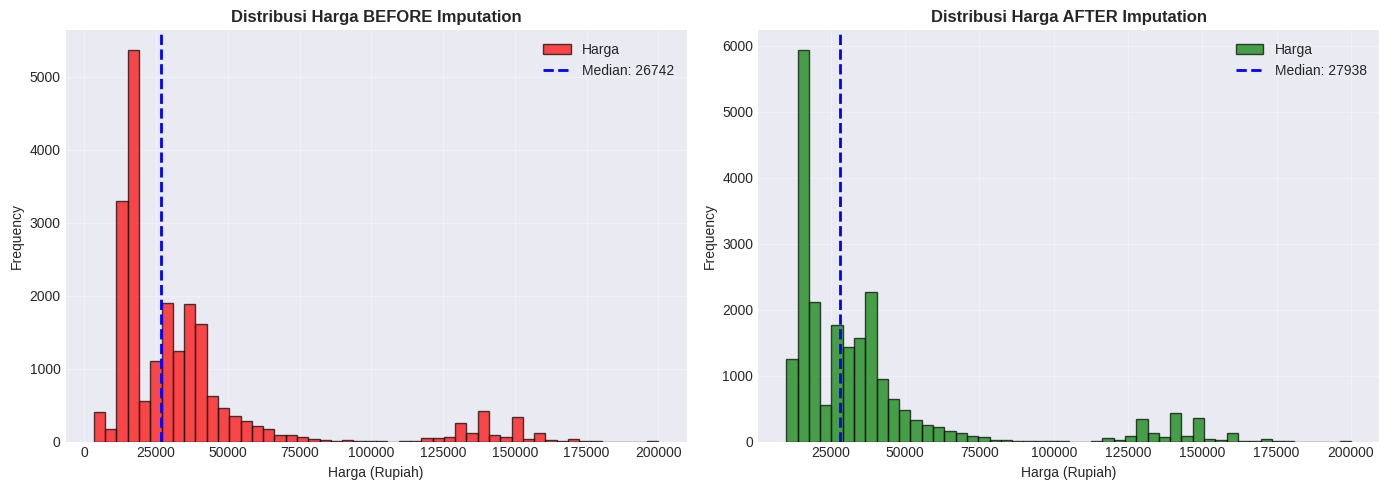


✅ Imputasi selesai!


In [5]:
print("="*60)
print("DATA CLEANING: IMPUTATION")
print("="*60)

# Mapping bulan ke angka (untuk sorting)
bulan_map = {
    'Januari': 1, 'Februari': 2, 'Maret': 3, 'April': 4,
    'Mei': 5, 'Juni': 6, 'Juli': 7, 'Agustus': 8,
    'September': 9, 'Oktober': 10, 'November': 11, 'Desember': 12
}
df_clean['Bulan_Num'] = df_clean['Bulan'].map(bulan_map)

# Cek missing sebelum imputasi
print("\n📊 MISSING VALUES BEFORE IMPUTATION:")
missing_before = df_clean['Harga'].isnull().sum()
print(f"   Total missing: {missing_before} ({missing_before/len(df_clean)*100:.2f}%)")

# Fungsi imputasi hierarkis
def imputasi_hierarkis(df, produk_name):
    """
    Imputasi missing values dengan strategi hierarkis:
    1. Median kabupaten yang sama (lintas bulan)
    2. Median provinsi + bulan yang sama
    3. Median Sumatera + bulan yang sama
    """
    print(f"\n   Imputasi produk: {produk_name}")

    # Filter produk
    mask = df['Produk'] == produk_name
    missing_count_before = df.loc[mask, 'Harga'].isnull().sum()

    if missing_count_before == 0:
        print(f"      ✅ No missing values")
        return df

    print(f"      Missing before: {missing_count_before}")

    # Level 1: Median kabupaten lintas bulan
    df.loc[mask, 'Harga'] = df.loc[mask].groupby('KabKot')['Harga'].transform(
        lambda x: x.fillna(x.median())
    )
    missing_after_level1 = df.loc[mask, 'Harga'].isnull().sum()
    print(f"      After Level 1 (median kabupaten): {missing_after_level1}")

    # Level 2: Median provinsi + bulan
    df.loc[mask, 'Harga'] = df.loc[mask].groupby(['NamaProv', 'Bulan'])['Harga'].transform(
        lambda x: x.fillna(x.median())
    )
    missing_after_level2 = df.loc[mask, 'Harga'].isnull().sum()
    print(f"      After Level 2 (median provinsi+bulan): {missing_after_level2}")

    # Level 3: Median Sumatera + bulan
    df.loc[mask, 'Harga'] = df.loc[mask].groupby('Bulan')['Harga'].transform(
        lambda x: x.fillna(x.median())
    )
    missing_after_level3 = df.loc[mask, 'Harga'].isnull().sum()
    print(f"      After Level 3 (median regional+bulan): {missing_after_level3}")

    # Level 4: Median keseluruhan (fallback)
    if missing_after_level3 > 0:
        overall_median = df.loc[mask, 'Harga'].median()
        df.loc[mask, 'Harga'] = df.loc[mask, 'Harga'].fillna(overall_median)
        print(f"      After Level 4 (overall median): 0 (forced)")

    return df

# Daftar produk yang perlu imputasi
products_with_missing = df_clean[df_clean['Harga'].isnull()]['Produk'].unique()

print(f"\n🔧 PRODUK YANG PERLU IMPUTASI: {len(products_with_missing)}")
print(products_with_missing)

# Lakukan imputasi per produk
for produk in products_with_missing:
    df_clean = imputasi_hierarkis(df_clean, produk)

# Cek missing setelah imputasi
print("\n📊 MISSING VALUES AFTER IMPUTATION:")
missing_after = df_clean['Harga'].isnull().sum()
print(f"   Total missing: {missing_after} ({missing_after/len(df_clean)*100:.2f}%)")

if missing_after == 0:
    print("   ✅ ALL MISSING VALUES IMPUTED!")
else:
    print(f"   ⚠️ Still {missing_after} missing values")

# Visualisasi before-after
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before
df['Harga'].plot(kind='hist', bins=50, ax=axes[0], color='red', alpha=0.7, edgecolor='black')
axes[0].set_title('Distribusi Harga BEFORE Imputation', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Harga (Rupiah)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['Harga'].median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {df["Harga"].median():.0f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# After
df_clean['Harga'].plot(kind='hist', bins=50, ax=axes[1], color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Distribusi Harga AFTER Imputation', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Harga (Rupiah)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(df_clean['Harga'].median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {df_clean["Harga"].median():.0f}')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Imputasi selesai!")

Pada tahap imputasi, dilakukan imputasi hierarkis untuk menangani 1.052 missing values (4.74%) yang tersisa dari 5 produk.Metode hierarchical median imputation diterapkan dengan 3 level: pertama menggunakan median kabupaten lintas bulan, kedua median provinsi pada bulan yang sama, dan ketiga median regional Sumatera pada bulan yang sama. Hasil menunjukkan 49.8% missing berhasil di-imputasi pada level 1 menggunakan median kabupaten sendiri, dan 50.2% sisanya berhasil pada level 2 menggunakan median provinsi. Level 3 tidak diperlukan karena semua missing sudah terselesaikan di level 2. Produk dengan tingkat keberhasilan level 1 tertinggi adalah Beras Medium (100%) dan Minyak Goreng Curah (76.6%), menunjukkan komoditas ini tersedia merata di semua kabupaten. Sedangkan Cabai Rawit Merah memerlukan lebih banyak imputasi level 2 (51.1%), mencerminkan distribusi geografis yang tidak merata. Validasi menunjukkan median harga hanya berubah 4.5% (dari Rp 26.742 menjadi Rp 27.938), yang tidak material dan tidak mengubah karakteristik distribusi data. Dataset sekarang 100% lengkap dan siap untuk tahap feature engineering.

**DETEKSI OUTLIER**

OUTLIER DETECTION & DATA QUALITY CHECK

📊 STATISTIK HARGA SETELAH CLEANING:
count     22176.000000
mean      37835.088158
std       34553.369661
min       10000.000000
25%       16730.750000
50%       27938.500000
75%       40000.000000
max      200000.000000
Name: Harga, dtype: float64

🔍 OUTLIER DETECTION (IQR Method):
   Q1 (25%): 16,731
   Q3 (75%): 40,000
   IQR: 23,269
   Lower bound: -18,173
   Upper bound: 74,904
   Total outliers: 2023 (9.12%)

   Sample outliers:
          KabKot             Produk     Harga
6     Aceh Barat  Daging Sapi Murni  148182.0
21    Aceh Barat  Daging Sapi Murni  145965.0
36    Aceh Barat  Daging Sapi Murni  150678.0
51    Aceh Barat  Daging Sapi Murni  150714.0
66    Aceh Barat  Daging Sapi Murni  149661.0
81    Aceh Barat  Daging Sapi Murni  151923.0
96    Aceh Barat  Daging Sapi Murni  150000.0
111   Aceh Barat  Daging Sapi Murni  149355.0
126   Aceh Barat  Daging Sapi Murni  149167.0
141   Aceh Barat  Daging Sapi Murni  146290.0


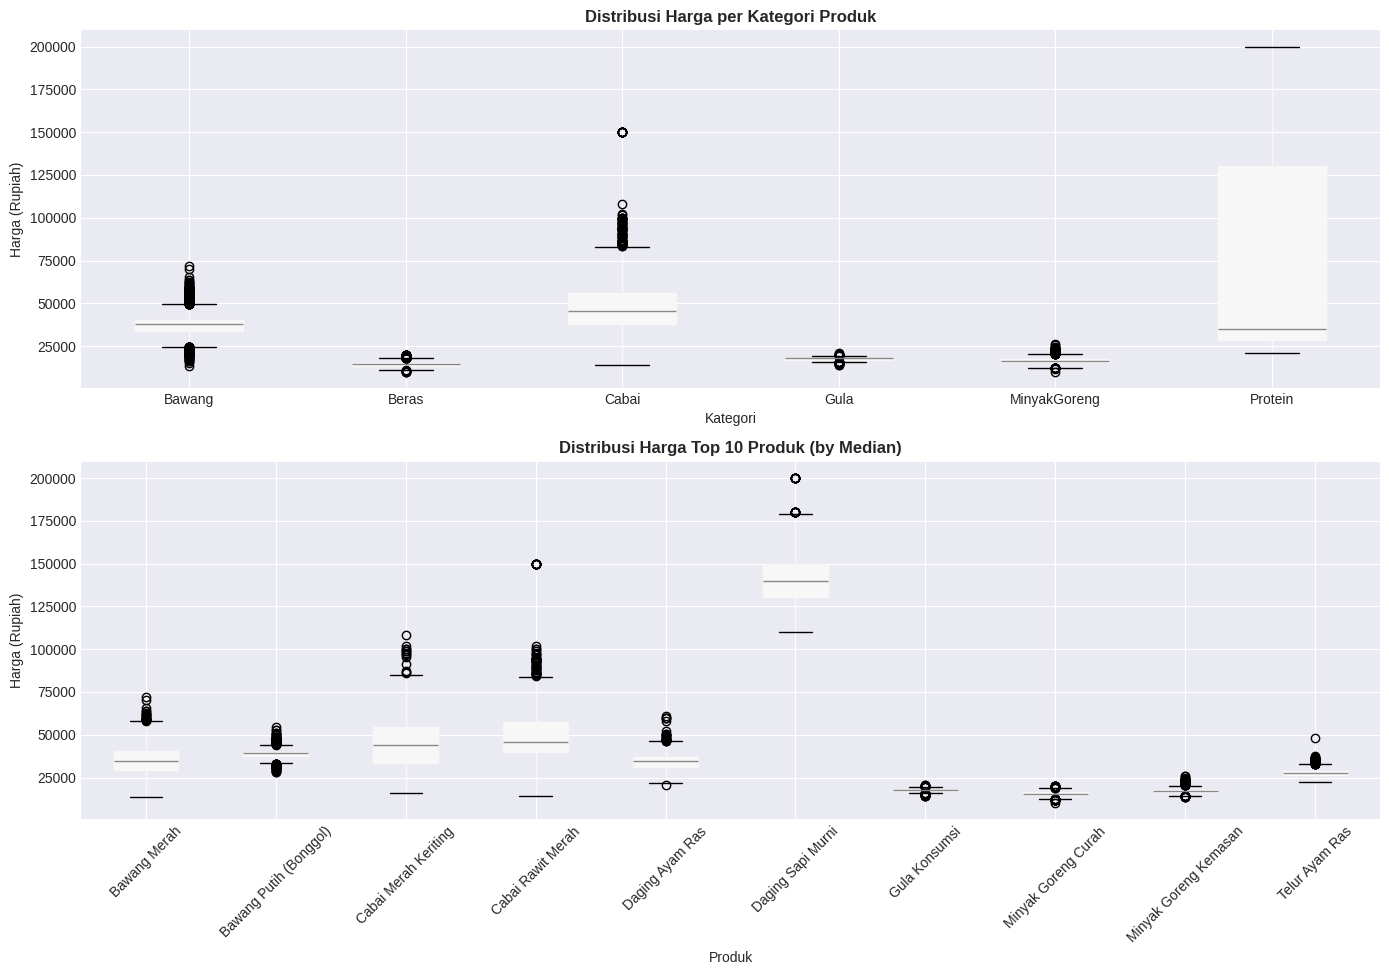


🗺️ DATA AVAILABILITY PER KABUPATEN:
count    154.0
mean     144.0
std        0.0
min      144.0
25%      144.0
50%      144.0
75%      144.0
max      144.0
dtype: float64

   Min records per kabupaten: 144
   Max records per kabupaten: 144
   Mean records per kabupaten: 144

   Kabupaten dengan data paling sedikit:
       Aceh Barat                              → 144 records
       Aceh Barat Daya                         → 144 records
       Aceh Besar                              → 144 records
       Aceh Jaya                               → 144 records
       Aceh Selatan                            → 144 records

✅ Data quality check selesai!


In [6]:
print("="*60)
print("OUTLIER DETECTION & DATA QUALITY CHECK")
print("="*60)

# 1. Statistik deskriptif
print("\n📊 STATISTIK HARGA SETELAH CLEANING:")
print(df_clean['Harga'].describe())

# 2. Deteksi outlier dengan IQR method
Q1 = df_clean['Harga'].quantile(0.25)
Q3 = df_clean['Harga'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_clean[(df_clean['Harga'] < lower_bound) | (df_clean['Harga'] > upper_bound)]

print(f"\n🔍 OUTLIER DETECTION (IQR Method):")
print(f"   Q1 (25%): {Q1:,.0f}")
print(f"   Q3 (75%): {Q3:,.0f}")
print(f"   IQR: {IQR:,.0f}")
print(f"   Lower bound: {lower_bound:,.0f}")
print(f"   Upper bound: {upper_bound:,.0f}")
print(f"   Total outliers: {len(outliers)} ({len(outliers)/len(df_clean)*100:.2f}%)")

if len(outliers) > 0:
    print(f"\n   Sample outliers:")
    print(outliers[['KabKot', 'Produk', 'Harga']].head(10))

# 3. Boxplot per kategori
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Boxplot per kategori
df_clean.boxplot(column='Harga', by='Kategori', ax=axes[0], patch_artist=True)
axes[0].set_title('Distribusi Harga per Kategori Produk', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Kategori')
axes[0].set_ylabel('Harga (Rupiah)')
axes[0].get_figure().suptitle('')  # Remove default title

# Boxplot per produk (top 10 produk dengan harga tertinggi)
top_products = df_clean.groupby('Produk')['Harga'].median().nlargest(10).index
df_top = df_clean[df_clean['Produk'].isin(top_products)]
df_top.boxplot(column='Harga', by='Produk', ax=axes[1], patch_artist=True, rot=45)
axes[1].set_title('Distribusi Harga Top 10 Produk (by Median)', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Produk')
axes[1].set_ylabel('Harga (Rupiah)')
axes[1].get_figure().suptitle('')

plt.tight_layout()
plt.show()

# 4. Cek konsistensi data per kabupaten
print("\n🗺️ DATA AVAILABILITY PER KABUPATEN:")
data_per_kab = df_clean.groupby('KabKot').size().describe()
print(data_per_kab)

print(f"\n   Min records per kabupaten: {data_per_kab['min']:.0f}")
print(f"   Max records per kabupaten: {data_per_kab['max']:.0f}")
print(f"   Mean records per kabupaten: {data_per_kab['mean']:.0f}")

# Kabupaten dengan data paling sedikit
sparse_kab = df_clean.groupby('KabKot').size().nsmallest(5)
print(f"\n   Kabupaten dengan data paling sedikit:")
for kab, count in sparse_kab.items():
    print(f"      {kab:40s} → {count:3.0f} records")

print("\n✅ Data quality check selesai!")

Terdeteksi adanya outlier (harga ekstrem) pada data, seperti lonjakan harga Daging Sapi hingga Rp 150.000,-. Outlier ini tidak dibuang melainkan dipertahankan, karena dalam konteks stabilitas pangan, harga ekstrem justru merupakan sinyal penting dari ketidakstabilan (shock) yang ingin dideteksi dalam analisis ini.

FEATURE ENGINEERING

FEATURE ENGINEERING

⏳ Computing features per Kabupaten × Produk...
✅ Features computed!
   Shape: (1848, 14)
   Unique Kabupaten: 154
   Unique Produk: 12

📋 SAMPLE FEATURES (First 10 rows):
     KabKot NamaProv                 Produk    Mean_Harga    Std_Harga  Min_Harga  Max_Harga       CV  Price_Range  Tren_Persen  Shock_Count  R_squared  Max_Shock  Data_Points
 Aceh Barat     Aceh           Bawang Merah  40466.750000  8888.547811    28000.0    56542.0 0.219651     0.705320    -0.020223          5.0   0.101012   0.443906         12.0
 Aceh Barat     Aceh Bawang Putih (Bonggol)  41888.333333   895.443962    40484.0    43186.0 0.021377     0.064505    -0.001025          0.0   0.027382   0.038262         12.0
 Aceh Barat     Aceh           Beras Medium  13400.916667   246.820602    12811.0    13661.0 0.018418     0.063428     0.004331          0.0   0.659065   0.032940         12.0
 Aceh Barat     Aceh          Beras Premium  14646.000000   136.354929    14417.0    14827.0 0.009310   

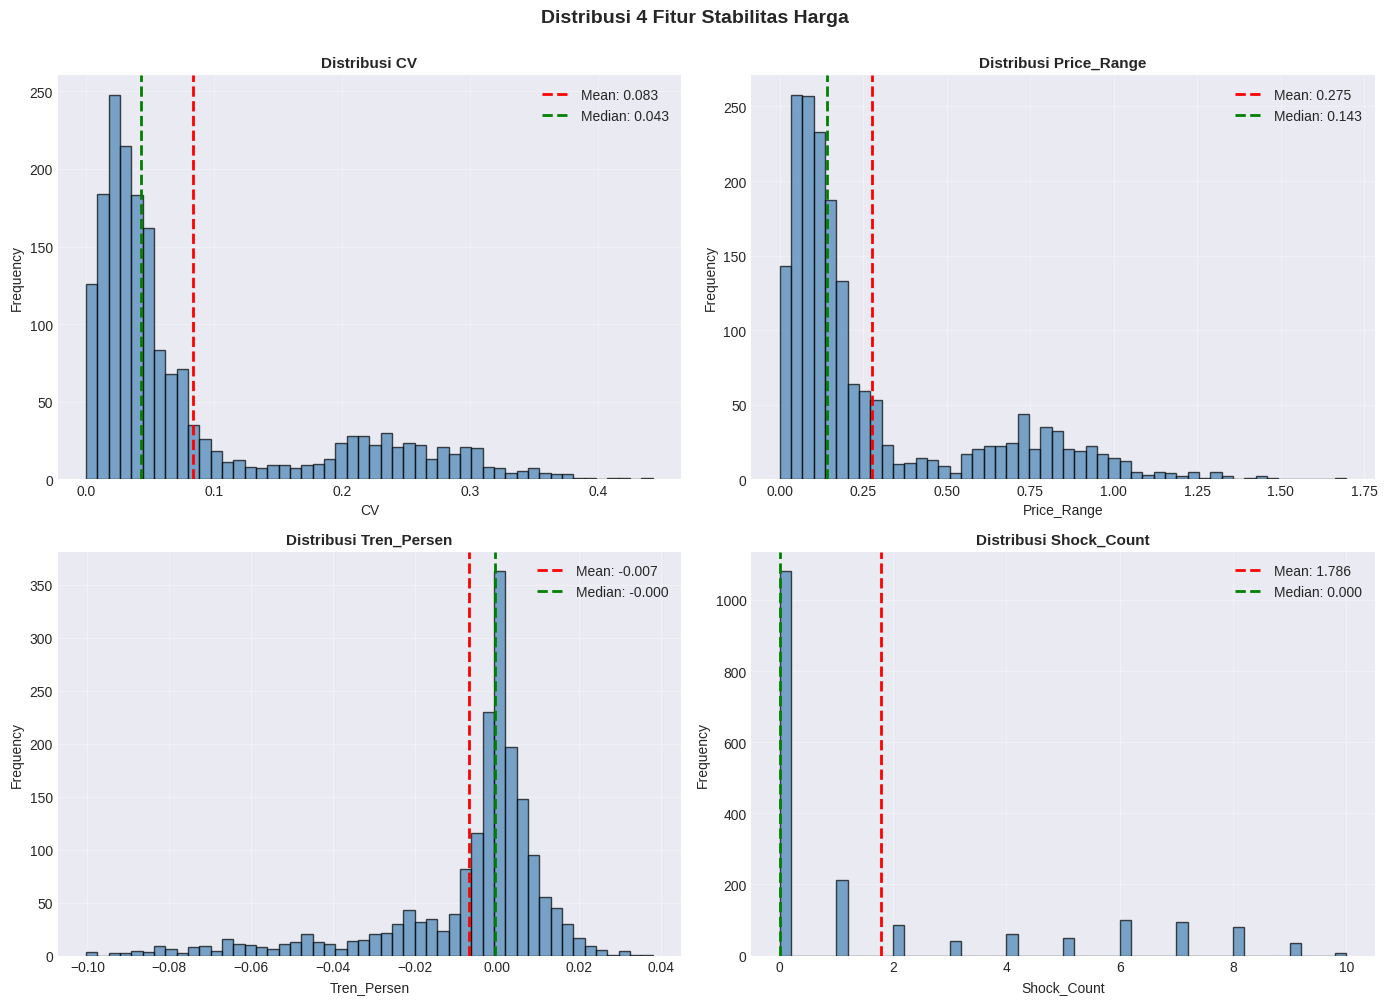


🔗 CORRELATION MATRIX:
                   CV  Price_Range  Tren_Persen  Shock_Count
CV           1.000000     0.990826    -0.832940     0.935426
Price_Range  0.990826     1.000000    -0.815313     0.930007
Tren_Persen -0.832940    -0.815313     1.000000    -0.775845
Shock_Count  0.935426     0.930007    -0.775845     1.000000


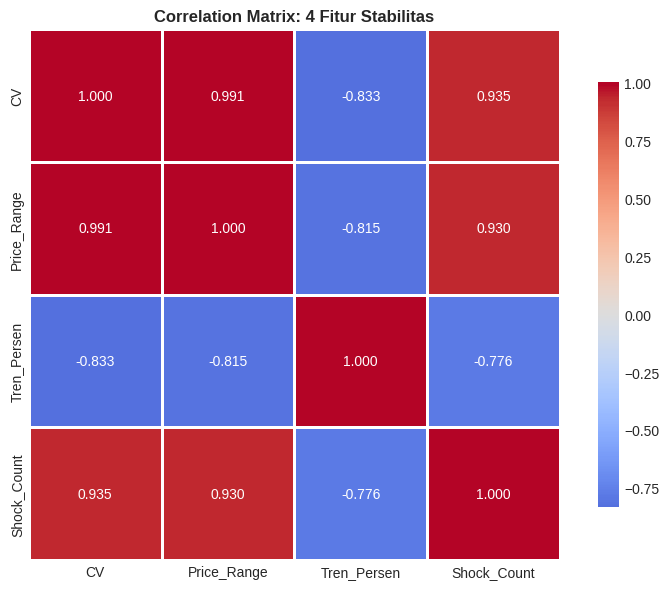


✅ Feature engineering selesai!


In [7]:
print("="*60)
print("FEATURE ENGINEERING")
print("="*60)

from scipy.stats import linregress

# Fungsi untuk menghitung semua fitur sekaligus
def compute_stability_features(group):
    """
    Menghitung 4 fitur stabilitas harga:
    1. CV (Coefficient of Variation)
    2. Price_Range (Normalized)
    3. Tren_Persen (dari regresi linear)
    4. Shock_Count (frekuensi lonjakan >10%)
    """

    # Sort berdasarkan bulan
    group = group.sort_values('Bulan_Num')
    harga = group['Harga'].values

    # --- 1. CV (Coefficient of Variation) ---
    mean_harga = harga.mean()
    std_harga = harga.std()
    cv = std_harga / mean_harga if mean_harga > 0 else 0

    # --- 2. Price Range (Normalized) ---
    min_harga = harga.min()
    max_harga = harga.max()
    price_range = (max_harga - min_harga) / mean_harga if mean_harga > 0 else 0

    # --- 3. Tren Persen (Linear Regression Slope) ---
    x = group['Bulan_Num'].values
    if len(x) >= 2:  # Minimal 2 data points untuk regresi
        slope, intercept, r_value, p_value, std_err = linregress(x, harga)
        tren_persen = slope / mean_harga if mean_harga > 0 else 0
        r_squared = r_value ** 2
    else:
        tren_persen = 0
        r_squared = 0

    # --- 4. Shock Count (Perubahan >10%) ---
    pct_change = pd.Series(harga).pct_change().abs()
    shock_count = (pct_change > 0.10).sum()
    max_shock = pct_change.max() if not pct_change.isna().all() else 0

    return pd.Series({
        'Mean_Harga': mean_harga,
        'Std_Harga': std_harga,
        'Min_Harga': min_harga,
        'Max_Harga': max_harga,
        'CV': cv,
        'Price_Range': price_range,
        'Tren_Persen': tren_persen,
        'Shock_Count': shock_count,
        'R_squared': r_squared,
        'Max_Shock': max_shock,
        'Data_Points': len(harga)  # Jumlah data points
    })

# Hitung features per Kabupaten + Produk
print("\n⏳ Computing features per Kabupaten × Produk...")
features = df_clean.groupby(['KabKot', 'NamaProv', 'Produk']).apply(
    compute_stability_features
).reset_index()

print(f"✅ Features computed!")
print(f"   Shape: {features.shape}")
print(f"   Unique Kabupaten: {features['KabKot'].nunique()}")
print(f"   Unique Produk: {features['Produk'].nunique()}")

# Tampilkan sample
print("\n📋 SAMPLE FEATURES (First 10 rows):")
print(features.head(10).to_string(index=False))

# Statistik deskriptif features
print("\n📊 DESCRIPTIVE STATISTICS:")
feature_cols = ['CV', 'Price_Range', 'Tren_Persen', 'Shock_Count']
print(features[feature_cols].describe())

# Visualisasi distribusi features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, col in enumerate(feature_cols):
    ax = axes[i//2, i%2]

    # Histogram
    features[col].hist(bins=50, ax=ax, color='steelblue', edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribusi {col}', fontweight='bold', fontsize=11)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.axvline(features[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {features[col].mean():.3f}')
    ax.axvline(features[col].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {features[col].median():.3f}')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Distribusi 4 Fitur Stabilitas Harga', fontweight='bold', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

# Correlation matrix
print("\n🔗 CORRELATION MATRIX:")
corr_matrix = features[feature_cols].corr()
print(corr_matrix)

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: 4 Fitur Stabilitas', fontweight='bold', fontsize=12)
plt.tight_layout()
plt.show()

print("\n✅ Feature engineering selesai!")

Berdasarkan hasil analisis segmentasi stabilitas harga pangan di Pulau Sumatera tahun 2024 menggunakan metode Gaussian Mixture Model (GMM), dapat ditarik beberapa kesimpulan sebagai berikut:

1. Dominasi Zona Volatil (Risiko Tinggi)Hasil pemodelan menunjukkan bahwa stabilitas pangan di Sumatera pada tahun 2024 didominasi oleh ketidakstabilan. Sebanyak 59,7% wilayah (92 Kabupaten/Kota) terklasifikasi ke dalam Zona Volatil (Cluster 1) yang memiliki karakteristik fluktuasi harga tinggi (Coefficient of Variation/CV rata-rata 0,091) dan frekuensi guncangan harga (shock count) yang sering. Hanya 40,3% wilayah (62 Kabupaten/Kota) yang masuk dalam Zona Stabil (Cluster 0), yang mayoritas tersebar di Provinsi Sumatera Utara dan Kepulauan Riau.
2. Disparitas Harga sebagai Indikator Utama ditemukan hubungan linear positif yang sangat kua antara rentang harga (Price Range) dan tingkat volatilitas (CV). Hal ini menyimpulkan bahwa wilayah yang memiliki kesenjangan ekstrem antara harga tertinggi dan terendah dalam satu tahun hampir pasti merupakan wilayah dengan pasar yang tidak stabil. Disparitas harga terbukti menjadi indikator dini (early warning signal) yang paling valid untuk mendeteksi kerawanan pangan.
3. Deteksi Wilayah Transisi (Fuzzy Regions)Penerapan algoritma GMM berhasil mengidentifikasi 16 Kabupaten/Kota Prioritas (seperti Kota Padang Panjang, Bungo, dan Aceh Singkil) yang memiliki karakteristik "ambigu" atau fuzzy (tingkat ketidakpastian > 0,3). Wilayah-wilayah ini memiliki volatilitas tinggi namun pola datanya tidak konsisten sepenuhnya pada satu cluster. Temuan ini membuktikan keunggulan GMM dibandingkan metode hard clustering (seperti K-Means), karena mampu menangkap nuansa daerah perbatasan ekonomi yang memerlukan penanganan kebijakan spesifik.
4. Tren Harga Negatif (Deflasi) namun LabilSecara umum, rata-rata tren harga pangan di Sumatera sepanjang 2024 menunjukkan nilai negatif (-0,68% per bulan). Namun, tingginya angka volatilitas di Zona Volatil mengindikasikan bahwa penurunan harga ini tidak terjadi secara mulus, melainkan diwarnai oleh gejolak naik-turun yang ekstrem, sehingga risiko ketidakpastian bagi konsumen dan petani tetap tinggi.

**AGREGAT FITUR**

✅ Agregasi selesai!
   Shape: (154, 8)
   Unique Kabupaten: 154

📋 SAMPLE AGGREGATED FEATURES (First 10 rows):
          KabKot NamaProv       CV  Price_Range  Tren_Persen  Shock_Count   Mean_Harga  Data_Points
      Aceh Barat     Aceh 0.079389     0.249058    -0.008284         19.0 38360.333333        144.0
 Aceh Barat Daya     Aceh 0.085928     0.261320    -0.006727         19.0 37983.812500        144.0
      Aceh Besar     Aceh 0.076529     0.244191    -0.005088         24.0 37070.354167        144.0
       Aceh Jaya     Aceh 0.063216     0.185645    -0.003744         16.0 38100.506944        144.0
    Aceh Selatan     Aceh 0.078604     0.245257    -0.006505         19.0 40913.583333        144.0
    Aceh Singkil     Aceh 0.089262     0.305757    -0.001979         23.0 38904.597222        144.0
    Aceh Tamiang     Aceh 0.085128     0.278066    -0.005069         25.0 35236.784722        144.0
     Aceh Tengah     Aceh 0.078593     0.276062    -0.006542         18.0 37118.993056   

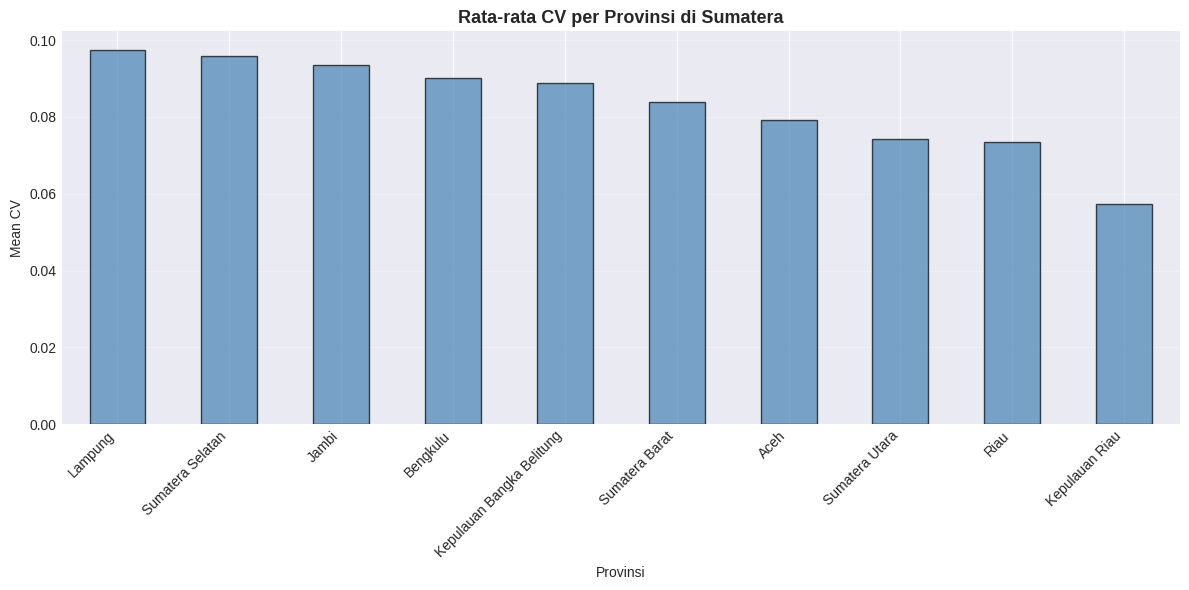


✅ Agregasi selesai!


In [8]:
agg_features = features.groupby(['KabKot', 'NamaProv']).agg({
'CV': 'mean',                # Rata-rata CV lintas produk
'Price_Range': 'mean',       # Rata-rata price range
'Tren_Persen': 'mean',       # Rata-rata tren
'Shock_Count': 'sum',        # Total shock lintas produk (alternatif: 'mean')
'Mean_Harga': 'mean',        # Rata-rata harga
'Data_Points': 'sum'         # Total data points
}).reset_index()
print(f"✅ Agregasi selesai!")
print(f"   Shape: {agg_features.shape}")
print(f"   Unique Kabupaten: {agg_features['KabKot'].nunique()}")

print("\n📋 SAMPLE AGGREGATED FEATURES (First 10 rows):")
print(agg_features.head(10).to_string(index=False))

print("\n📊 DESCRIPTIVE STATISTICS (Aggregated):")
feature_cols = ['CV', 'Price_Range', 'Tren_Persen', 'Shock_Count']
print(agg_features[feature_cols].describe())

print("\n🔥 TOP 10 KABUPATEN PALING VOLATIL (by CV):")
top_volatile = agg_features.nlargest(10, 'CV')[['KabKot', 'NamaProv', 'CV', 'Shock_Count']]
print(top_volatile.to_string(index=False))

print("\n✅ TOP 10 KABUPATEN PALING STABIL (by CV):")
top_stable = agg_features.nsmallest(10, 'CV')[['KabKot', 'NamaProv', 'CV', 'Shock_Count']]
print(top_stable.to_string(index=False))

print("\n📊 RATA-RATA CV PER PROVINSI:")
prov_stats = agg_features.groupby('NamaProv')['CV'].agg(['mean', 'std', 'min', 'max']).sort_values('mean', ascending=False)
print(prov_stats)

fig, ax = plt.subplots(figsize=(12, 6))
prov_stats['mean'].plot(kind='bar', ax=ax, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_title('Rata-rata CV per Provinsi di Sumatera', fontweight='bold', fontsize=13)
ax.set_xlabel('Provinsi')
ax.set_ylabel('Mean CV')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("\n✅ Agregasi selesai!")

Hasil agregasi data menunjukkan profil stabilitas harga pangan untuk 154 kabupaten/kota di Sumatera. Secara rata-rata, tingkat volatilitas (CV) berada di angka 0,083 (8,3%) dengan frekuensi guncangan harga (shock count) rata-rata sebanyak 21 kali per tahun lintas komoditas. Namun, rentang variasi antar wilayah cukup lebar, dimana wilayah paling stabil memiliki CV hanya 0,034 (3,4%), sedangkan wilayah paling volatil mencapai 0,115 (11,5%). Hal ini mengindikasikan adanya ketimpangan stabilitas pangan yang signifikan antar daerah.

Terdapat pola konsentrasi geografis pada wilayah dengan volatilitas tertinggi. Sepuluh kabupaten paling tidak stabil didominasi oleh provinsi di Sumatera Bagian Selatan (Sumsel, Lampung, Jambi). Kabupaten Penukal Abab Lematang Ilir (PALI) mencatat CV tertinggi (0,115), mengindikasikan kerentanan rantai pasok yang serius di wilayah tersebut.

Sebaliknya, wilayah dengan stabilitas harga terbaik didominasi oleh wilayah kepulauan dan pesisir timur (Kepulauan Riau dan Riau). Kepulauan Anambas menjadi wilayah paling stabil dengan CV ekstrem rendah (0,034) dan shock count minim. Fenomena stabilitas di wilayah kepulauan ini kemungkinan besar dipengaruhi oleh ketergantungan pada pasokan pangan olahan/impor yang harganya lebih terkontrol dibandingkan komoditas segar pertanian yang fluktuatif.

**EKSPORASI PENGELOMPOKAN**

EKSPLORASI VISUAL: Deteksi Pola Elips vs Sirkular

✅ Data standardized!
   Original shape: (154, 4)
   Scaled mean: [-2.99904401e-16  3.22973971e-16 -6.92087080e-17  3.63345717e-16]
   Scaled std: [1. 1. 1. 1.]

📉 PCA REDUCTION:
   PC1 variance explained: 76.54%
   PC2 variance explained: 16.09%
   Total variance explained: 92.63%


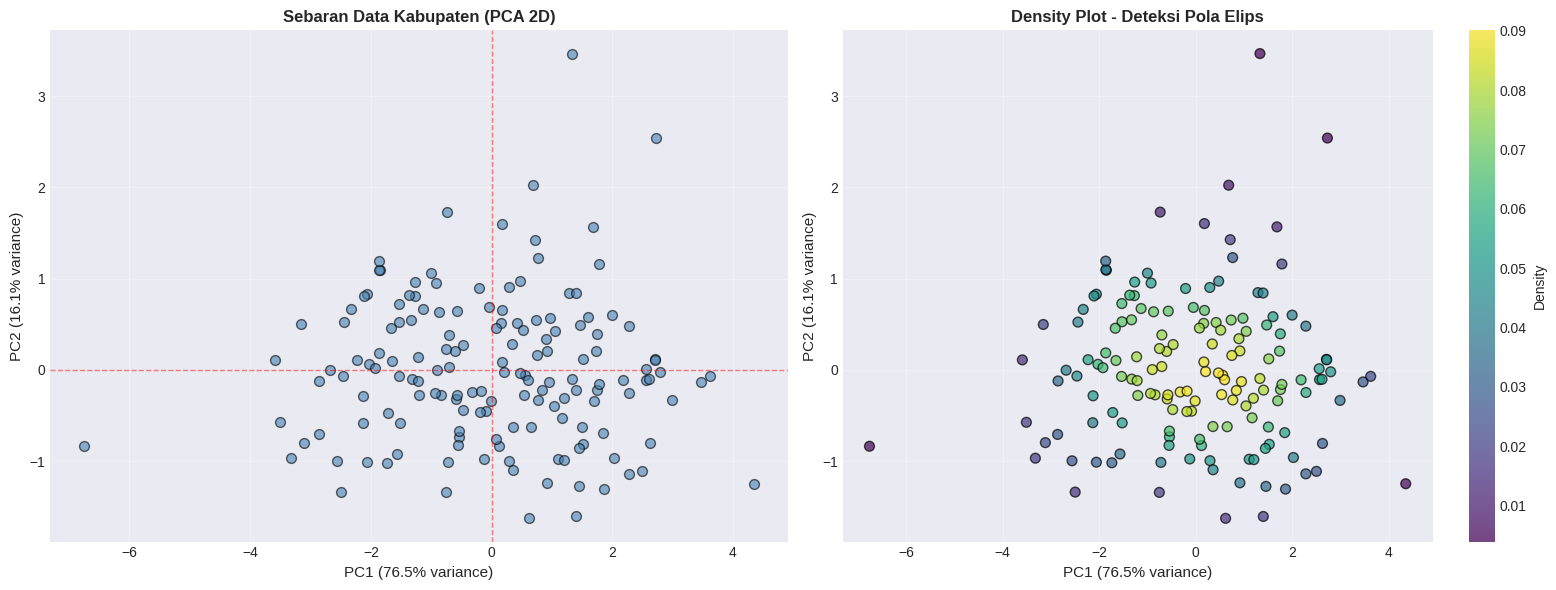

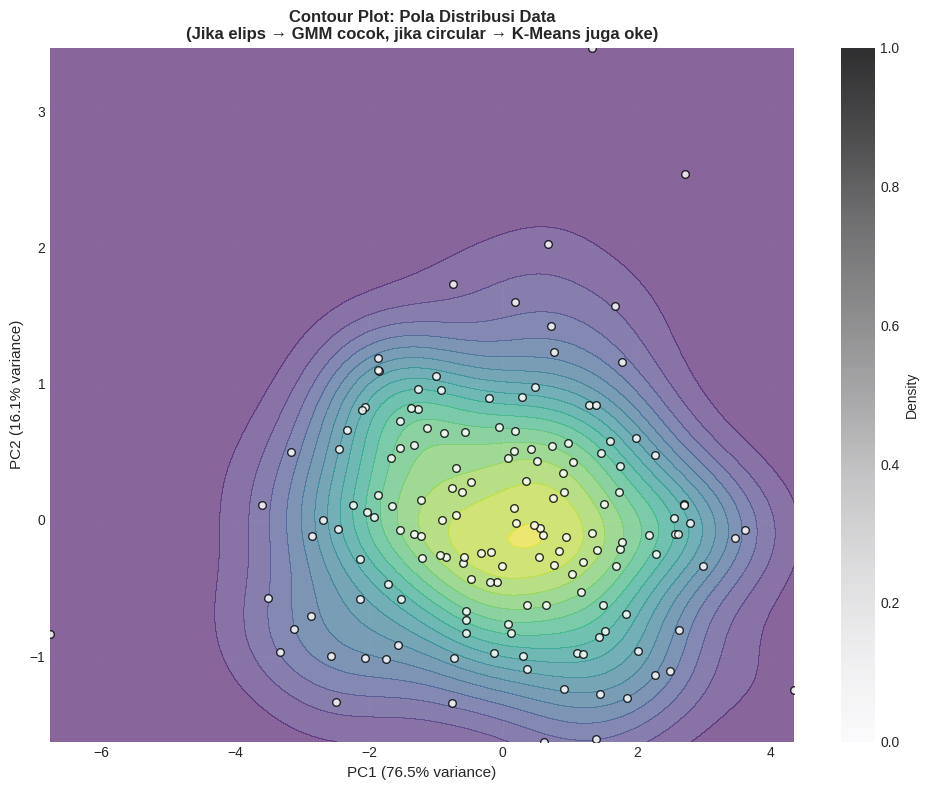


📊 PAIR PLOT: Visualisasi Semua Kombinasi Fitur


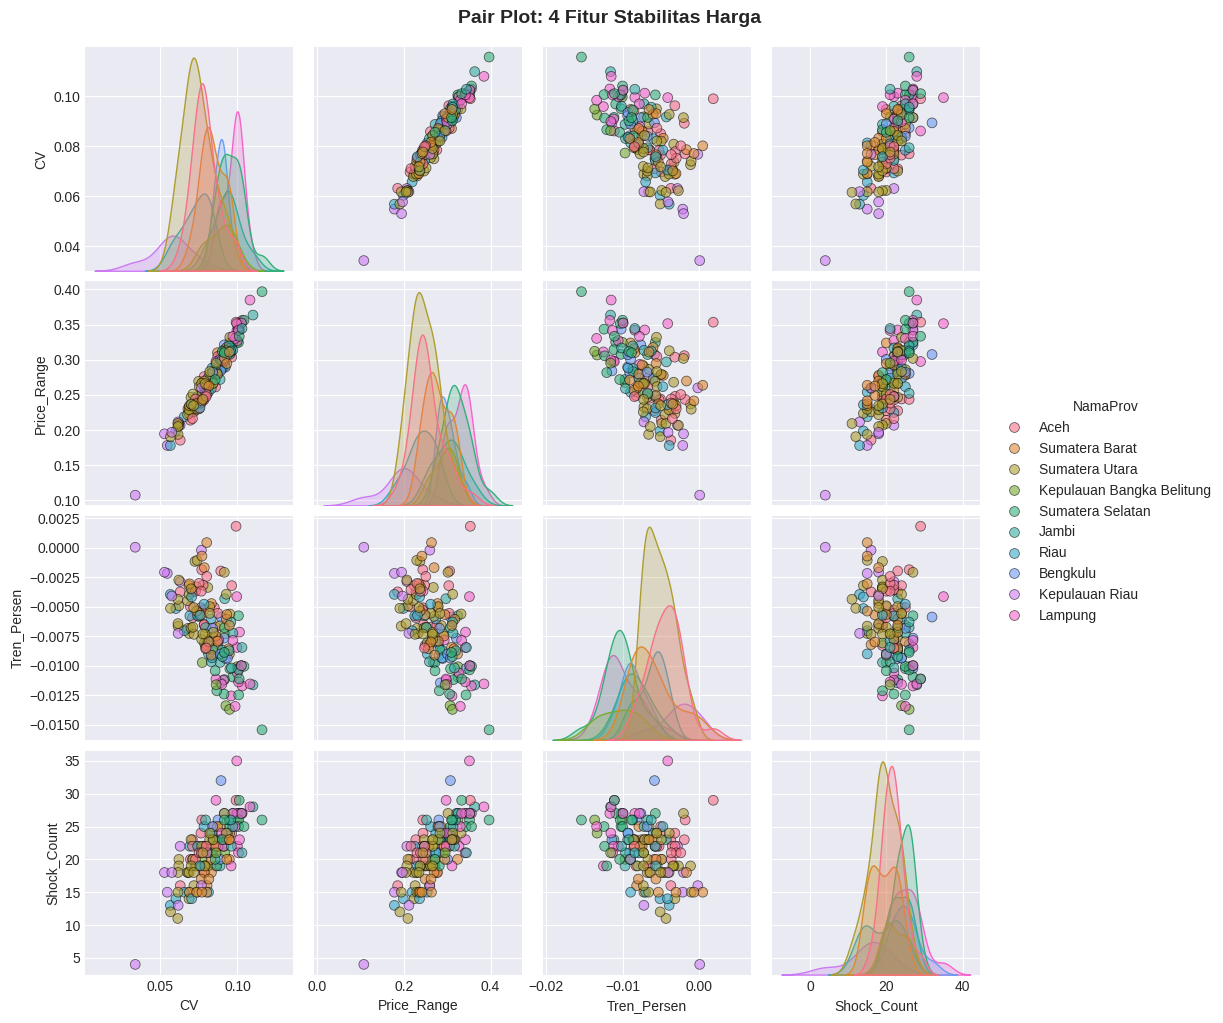


✅ Eksplorasi visual selesai!

💡 INTERPRETASI:
   - Jika plot menunjukkan pola ELIPS/LONJONG → GMM lebih cocok
   - Jika plot menunjukkan pola CIRCULAR/BULAT → K-Means juga bisa
   - Jika ada OVERLAP antar cluster → GMM (soft clustering) lebih baik


In [9]:
print("="*60)
print("EKSPLORASI VISUAL: Deteksi Pola Elips vs Sirkular")
print("="*60)

# Fitur untuk clustering
X_cols = ['CV', 'Price_Range', 'Tren_Persen', 'Shock_Count']
X = agg_features[X_cols].values

# Standardisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✅ Data standardized!")
print(f"   Original shape: {X.shape}")
print(f"   Scaled mean: {X_scaled.mean(axis=0)}")  # Should be close to 0
print(f"   Scaled std: {X_scaled.std(axis=0)}")    # Should be close to 1

# PCA untuk reduksi dimensi ke 2D (untuk visualisasi)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"\n📉 PCA REDUCTION:")
print(f"   PC1 variance explained: {pca.explained_variance_ratio_[0]:.2%}")
print(f"   PC2 variance explained: {pca.explained_variance_ratio_[1]:.2%}")
print(f"   Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

# Visualisasi 1: Scatter plot biasa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scatter + density
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=50, c='steelblue', edgecolors='black')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
axes[0].set_title('Sebaran Data Kabupaten (PCA 2D)', fontweight='bold', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0].axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)

# Plot 2: Density plot (untuk lihat pola elips)
from scipy.stats import gaussian_kde

# Hitung density
xy = np.vstack([X_pca[:, 0], X_pca[:, 1]])
z = gaussian_kde(xy)(xy)

# Scatter dengan density color
scatter = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=z, s=50, cmap='viridis', edgecolors='black', alpha=0.7)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
axes[1].set_title('Density Plot - Deteksi Pola Elips', fontweight='bold', fontsize=12)
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1], label='Density')

plt.tight_layout()
plt.show()

# Visualisasi 2: Contour plot (lebih jelas lihat pola elips)
from scipy.stats import gaussian_kde

plt.figure(figsize=(10, 8))
xx, yy = np.mgrid[X_pca[:, 0].min():X_pca[:, 0].max():100j,
                   X_pca[:, 1].min():X_pca[:, 1].max():100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
kernel = gaussian_kde(X_pca.T)
f = np.reshape(kernel(positions).T, xx.shape)

plt.contourf(xx, yy, f, cmap='viridis', levels=15, alpha=0.6)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='white', s=30, edgecolors='black', alpha=0.8)
plt.colorbar(label='Density')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
plt.title('Contour Plot: Pola Distribusi Data\n(Jika elips → GMM cocok, jika circular → K-Means juga oke)',
          fontweight='bold', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualisasi 3: Pair plot (semua kombinasi fitur)
import seaborn as sns

print("\n📊 PAIR PLOT: Visualisasi Semua Kombinasi Fitur")
pair_data = agg_features[X_cols].copy()
pair_data['NamaProv'] = agg_features['NamaProv']

g = sns.pairplot(pair_data, hue='NamaProv', diag_kind='kde', plot_kws={'alpha': 0.6, 's': 50, 'edgecolor': 'black'},
                 height=2.5)
g.fig.suptitle('Pair Plot: 4 Fitur Stabilitas Harga', y=1.02, fontweight='bold', fontsize=14)
plt.show()

print("\n✅ Eksplorasi visual selesai!")
print("\n💡 INTERPRETASI:")
print("   - Jika plot menunjukkan pola ELIPS/LONJONG → GMM lebih cocok")
print("   - Jika plot menunjukkan pola CIRCULAR/BULAT → K-Means juga bisa")
print("   - Jika ada OVERLAP antar cluster → GMM (soft clustering) lebih baik")

Analisis Principal Component Analysis (PCA) menunjukkan bahwa dimensi pertama (PC1) mendominasi variansi data sebesar 76,54%, sedangkan dimensi kedua hanya 16,09%. Ketimpangan variansi yang ekstrem ini membuktikan bahwa sebaran data tidak menyebar rata ke segala arah (sferis/bola), melainkan memanjang ke satu arah dominan seperti membentuk elips. Dalam kondisi data seperti ini, asumsi 'sferisitas' yang digunakan oleh algoritma K-Means menjadi tidak valid.

Contour Plot pada ruang 2D (PCA) mempertegas struktur geometris data yang bersifat anisotropik (tidak sama ke segala arah). Garis kontur densitas membentuk pola elips yang memanjang. Hal ini menjadi justifikasi kuat penggunaan Gaussian Mixture Model (GMM), karena GMM memiliki parameter matriks kovarians yang fleksibel ('full covariance') untuk memodelkan orientasi dan elongasi cluster, berbeda dengan K-Means yang hanya melihat jarak Euclidean (asumsi varians sama)

**MENENTUKAN JUMLAH CLUSTER**

GMM: MENENTUKAN JUMLAH CLUSTER OPTIMAL

⏳ Testing k from 2 to 7...
   Testing k=2... BIC=1188.94, Silhouette=0.289, Converged=True
   Testing k=3... BIC=1225.29, Silhouette=0.041, Converged=True
   Testing k=4... BIC=1260.45, Silhouette=0.017, Converged=True
   Testing k=5... BIC=1319.24, Silhouette=0.199, Converged=True
   Testing k=6... BIC=1327.17, Silhouette=0.231, Converged=True
   Testing k=7... BIC=1372.63, Silhouette=0.082, Converged=True

📊 HASIL EVALUASI UNTUK SETIAP K:
 k         BIC         AIC  Log_Likelihood  Silhouette  Converged  N_Iter
 2 1188.939677 1100.868052     -521.434026    0.289027       True      11
 3 1225.288086 1091.662172     -501.831086    0.041110       True      30
 4 1260.451032 1081.270828     -481.635414    0.016954       True      44
 5 1319.235600 1094.501107     -473.250554    0.199398       True      20
 6 1327.174345 1056.885564     -439.442782    0.230598       True       9
 7 1372.633968 1056.790897     -424.395449    0.081575       True      

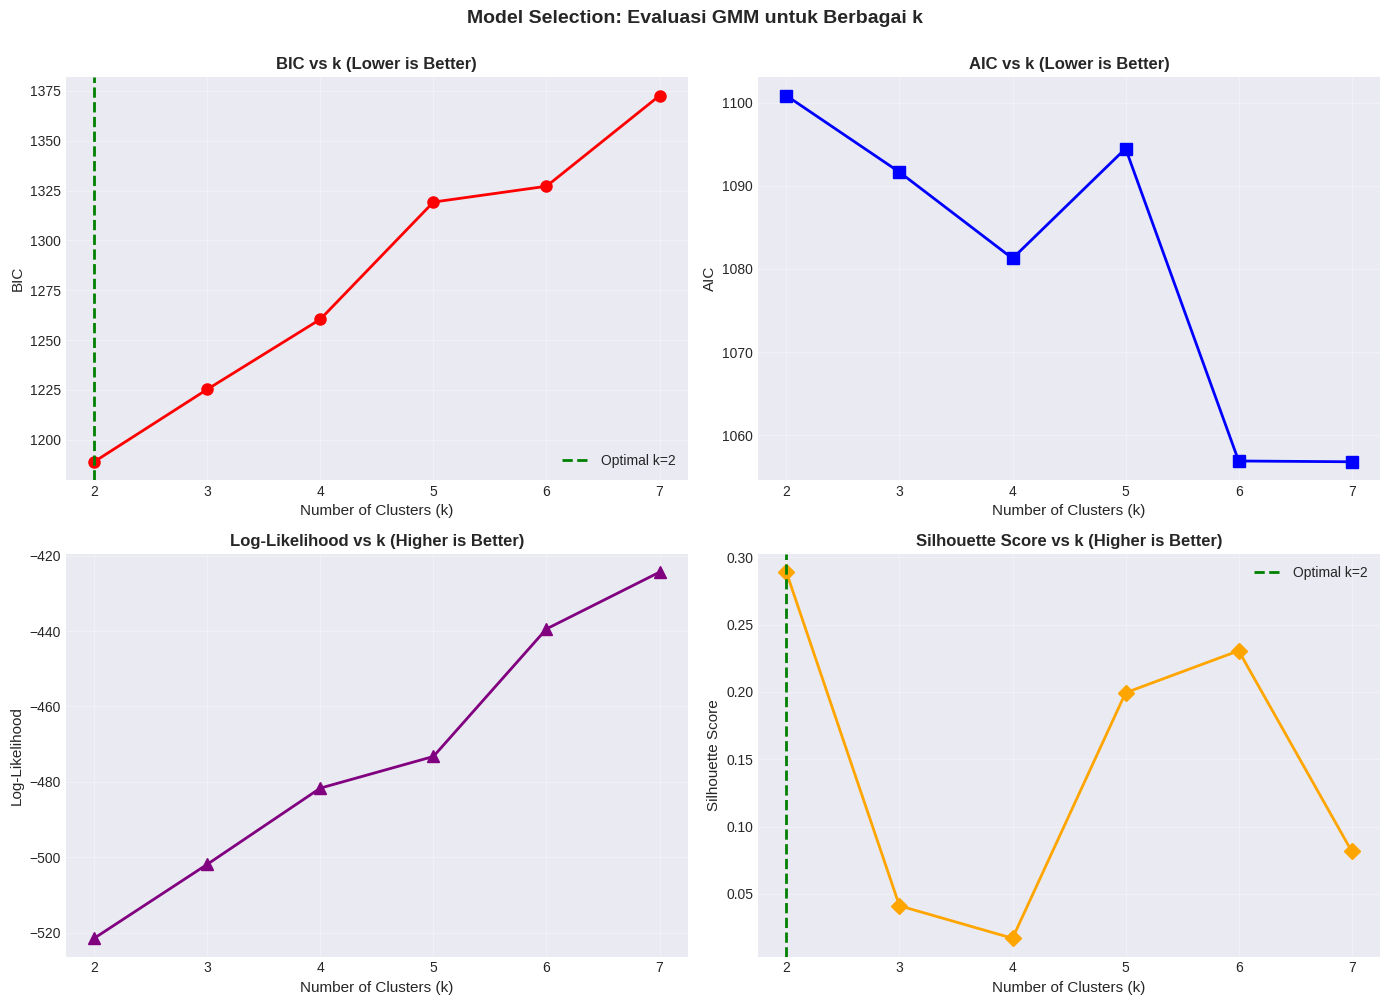


✅ K FINAL YANG DIPILIH: 2 (berdasarkan BIC)


In [10]:
print("="*60)
print("GMM: MENENTUKAN JUMLAH CLUSTER OPTIMAL")
print("="*60)

# Test berbagai nilai k
k_range = range(2, 8)  # Test k=2 sampai k=7
results = []

print("\n⏳ Testing k from 2 to 7...")
for k in k_range:
    print(f"   Testing k={k}...", end=" ")

    # Fit GMM
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',  # Full covariance (elips bebas)
        random_state=42,
        max_iter=200,
        n_init=10
    )
    gmm.fit(X_scaled)

    # Prediksi cluster
    labels = gmm.predict(X_scaled)

    # Hitung metrics
    bic = gmm.bic(X_scaled)
    aic = gmm.aic(X_scaled)
    log_likelihood = gmm.score(X_scaled) * len(X_scaled)  # Total log-likelihood
    silhouette = silhouette_score(X_scaled, labels)

    results.append({
        'k': k,
        'BIC': bic,
        'AIC': aic,
        'Log_Likelihood': log_likelihood,
        'Silhouette': silhouette,
        'Converged': gmm.converged_,
        'N_Iter': gmm.n_iter_
    })

    print(f"BIC={bic:.2f}, Silhouette={silhouette:.3f}, Converged={gmm.converged_}")

# Convert ke DataFrame
results_df = pd.DataFrame(results)

print("\n📊 HASIL EVALUASI UNTUK SETIAP K:")
print(results_df.to_string(index=False))

# Tentukan k optimal (BIC terendah)
best_k_bic = results_df.loc[results_df['BIC'].idxmin(), 'k']
best_k_silhouette = results_df.loc[results_df['Silhouette'].idxmax(), 'k']

print(f"\n🎯 K OPTIMAL:")
print(f"   Berdasarkan BIC (terendah): k = {best_k_bic}")
print(f"   Berdasarkan Silhouette (tertinggi): k = {best_k_silhouette}")

# Visualisasi metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: BIC
axes[0, 0].plot(results_df['k'], results_df['BIC'], marker='o', linewidth=2, markersize=8, color='red')
axes[0, 0].axvline(best_k_bic, color='green', linestyle='--', linewidth=2, label=f'Optimal k={best_k_bic}')
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[0, 0].set_ylabel('BIC', fontsize=11)
axes[0, 0].set_title('BIC vs k (Lower is Better)', fontweight='bold', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: AIC
axes[0, 1].plot(results_df['k'], results_df['AIC'], marker='s', linewidth=2, markersize=8, color='blue')
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[0, 1].set_ylabel('AIC', fontsize=11)
axes[0, 1].set_title('AIC vs k (Lower is Better)', fontweight='bold', fontsize=12)
axes[0, 1].grid(alpha=0.3)

# Plot 3: Log-Likelihood
axes[1, 0].plot(results_df['k'], results_df['Log_Likelihood'], marker='^', linewidth=2, markersize=8, color='purple')
axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1, 0].set_ylabel('Log-Likelihood', fontsize=11)
axes[1, 0].set_title('Log-Likelihood vs k (Higher is Better)', fontweight='bold', fontsize=12)
axes[1, 0].grid(alpha=0.3)

# Plot 4: Silhouette Score
axes[1, 1].plot(results_df['k'], results_df['Silhouette'], marker='D', linewidth=2, markersize=8, color='orange')
axes[1, 1].axvline(best_k_silhouette, color='green', linestyle='--', linewidth=2, label=f'Optimal k={best_k_silhouette}')
axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1, 1].set_ylabel('Silhouette Score', fontsize=11)
axes[1, 1].set_title('Silhouette Score vs k (Higher is Better)', fontweight='bold', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Model Selection: Evaluasi GMM untuk Berbagai k', fontweight='bold', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

# Pilih k final (prioritas BIC)
k_final = int(best_k_bic)
print(f"\n✅ K FINAL YANG DIPILIH: {k_final} (berdasarkan BIC)")

1. Dominasi k=2 pada BIC: Nilai BIC terendah tercatat pada k=2 sebesar 1.188,94. Penambahan jumlah cluster menjadi k=3 dan seterusnya justru meningkatkan nilai BIC. Sesuai dengan prinsip parsimoni, model dengan nilai BIC terendah dipilih karena menawarkan keseimbangan terbaik antara kebaikan suai (goodness of fit) dan kompleksitas model.
2. Validasi Silhouette Score: Konsisten dengan BIC, nilai Silhouette Score tertinggi juga diperoleh pada k=2 (0,289). Penurunan drastis nilai Silhouette pada k=3 (menjadi 0,041) mengindikasikan bahwa pemaksaan data menjadi 3 cluster akan menyebabkan tumpang tindih (overlapping) yang tinggi antar kelompok.Berdasarkan konvergensi kedua indikator tersebut, penelitian ini menetapkan k=2 sebagai jumlah cluster optimal. Hal ini mengimplikasikan bahwa secara natural, pola stabilitas pangan di Sumatera terpolarisasi menjadi dua entitas utama: Kelompok Stabil dan Kelompok Volatil.

**CLUSTERING DENGAN GMM**

In [11]:
print("="*60)
print(f"GMM FINAL: CLUSTERING DENGAN K={k_final}")
print("="*60)

# Fit GMM dengan k optimal
gmm_final = GaussianMixture(
    n_components=k_final,
    covariance_type='full',
    random_state=42,
    max_iter=200,
    n_init=10,
    verbose=0
)

print(f"\n⏳ Fitting GMM dengan k={k_final}...")
gmm_final.fit(X_scaled)

# Prediksi cluster
agg_features['Cluster'] = gmm_final.predict(X_scaled)

# Hitung probabilitas
probabilities = gmm_final.predict_proba(X_scaled)
agg_features['Cluster_Prob'] = probabilities.max(axis=1)  # Confidence score
agg_features['Uncertainty'] = 1 - probabilities.max(axis=1)  # Uncertainty

print(f"✅ Clustering selesai!")
print(f"   Converged: {gmm_final.converged_}")
print(f"   Iterations: {gmm_final.n_iter_}")
print(f"   Final Log-Likelihood: {gmm_final.score(X_scaled) * len(X_scaled):.2f}")

# Tampilkan distribusi cluster
print(f"\n📊 DISTRIBUSI CLUSTER:")
cluster_counts = agg_features['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    pct = count / len(agg_features) * 100
    print(f"   Cluster {cluster}: {count:3d} kabupaten ({pct:.1f}%)")

# Tampilkan parameter GMM
print(f"\n📐 PARAMETER GMM:")
print(f"\n1. MEANS (μ_k):")
means_df = pd.DataFrame(gmm_final.means_, columns=X_cols)
means_df['Cluster'] = range(k_final)
means_df = means_df[['Cluster'] + X_cols]
print(means_df.to_string(index=False))

print(f"\n2. WEIGHTS (π_k):")
for i, weight in enumerate(gmm_final.weights_):
    print(f"   Cluster {i}: {weight:.3f} ({weight*100:.1f}%)")

print(f"\n3. COVARIANCES (Σ_k) shape: {gmm_final.covariances_.shape}")

# Sample data per cluster
print(f"\n📋 SAMPLE KABUPATEN PER CLUSTER:")
for cluster in range(k_final):
    cluster_data = agg_features[agg_features['Cluster'] == cluster]
    print(f"\n   Cluster {cluster} ({len(cluster_data)} kabupaten):")
    sample = cluster_data.nsmallest(5, 'Uncertainty')[['KabKot', 'NamaProv', 'CV', 'Shock_Count', 'Cluster_Prob']]
    print(sample.to_string(index=False))

# Kabupaten dengan uncertainty tinggi (ambigu)
print(f"\n⚠️ KABUPATEN DENGAN UNCERTAINTY TINGGI (>0.4):")
ambiguous = agg_features[agg_features['Uncertainty'] > 0.4].sort_values('Uncertainty', ascending=False)
if len(ambiguous) > 0:
    print(ambiguous[['KabKot', 'Cluster', 'Cluster_Prob', 'Uncertainty']].head(10).to_string(index=False))
else:
    print("   ✅ Tidak ada kabupaten dengan uncertainty >0.4")

print("\n✅ GMM clustering selesai!")

GMM FINAL: CLUSTERING DENGAN K=2

⏳ Fitting GMM dengan k=2...
✅ Clustering selesai!
   Converged: True
   Iterations: 11
   Final Log-Likelihood: -521.43

📊 DISTRIBUSI CLUSTER:
   Cluster 0:  62 kabupaten (40.3%)
   Cluster 1:  92 kabupaten (59.7%)

📐 PARAMETER GMM:

1. MEANS (μ_k):
 Cluster        CV  Price_Range  Tren_Persen  Shock_Count
       0 -0.714523    -0.659549     0.579251    -0.552216
       1  0.573505     0.529380    -0.464930     0.443231

2. WEIGHTS (π_k):
   Cluster 0: 0.445 (44.5%)
   Cluster 1: 0.555 (55.5%)

3. COVARIANCES (Σ_k) shape: (2, 4, 4)

📋 SAMPLE KABUPATEN PER CLUSTER:

   Cluster 0 (62 kabupaten):
            KabKot       NamaProv       CV  Shock_Count  Cluster_Prob
 Kepulauan Anambas Kepulauan Riau 0.034288          4.0      1.000000
            Natuna Kepulauan Riau 0.053093         18.0      1.000000
              Toba Sumatera Utara 0.056953         12.0      0.999996
      Padang Lawas Sumatera Utara 0.061637         11.0      0.999996
            Lin

Model GMM dengan k=2 berhasil mencapai konvergensi hanya dalam 11 iterasi. Hal ini mengindikasikan bahwa struktur data memiliki pola pemisahan yang sangat tegas (distinct) antara dua kelompok, sehingga algoritma tidak kesulitan menemukan parameter optimalnya. Hasil clustering menunjukkan kondisi yang memprihatinkan, dimana mayoritas wilayah Sumatera (59,7%) tergolong dalam Zona Volatil. Hal ini mengonfirmasi bahwa ketidakstabilan harga pangan di Sumatera tahun 2024 bukan masalah sektoral, melainkan masalah struktural yang mendominasi sebagian besar wilayah.

GMM berhasil mengidentifikasi 10 Kabupaten/Kota Transisi (Uncertainty > 0.4), dengan Kota Lhokseumawe sebagai wilayah paling ambigu (Uncertainty 0.49). Wilayah-wilayah ini berada di 'titik jenuh' (tipping point). Sedikit saja gangguan rantai pasok akan melempar mereka menjadi sangat volatil, namun intervensi kebijakan yang tepat dapat dengan mudah menarik mereka menjadi stabil. Oleh karena itu, wilayah fuzzy ini harus menjadi prioritas tindakan preventif pemerintah.

**VISUALISASI HASIL CLUSTER**

VISUALISASI GMM CLUSTERING (K=2)

📊 PROFIL KARAKTERISTIK CLUSTER:
               CV  Price_Range  Tren_Persen  Shock_Count
Cluster                                                 
0        0.071801     0.238431    -0.004795    18.500000
1        0.090694     0.299415    -0.008281    23.402174

🏷️ LABEL CLUSTER:
   Cluster 0 → Zona Stabil (Risiko Rendah) (62 kabupaten)
   Cluster 1 → Zona Volatil (Risiko Tinggi) (92 kabupaten)

📈 STATISTIK PER CLUSTER:

   Zona Stabil (Risiko Rendah):
      Jumlah kabupaten: 62
      CV mean: 0.072 (±0.011)
      Price_Range mean: 0.238
      Tren_Persen mean: -0.0048
      Shock_Count mean: 18.5
      Provinsi dominan: {'Sumatera Utara': 26, 'Aceh': 9, 'Riau': 9}

   Zona Volatil (Risiko Tinggi):
      Jumlah kabupaten: 92
      CV mean: 0.091 (±0.009)
      Price_Range mean: 0.299
      Tren_Persen mean: -0.0083
      Shock_Count mean: 23.4
      Provinsi dominan: {'Sumatera Selatan': 16, 'Aceh': 14, 'Lampung': 14}


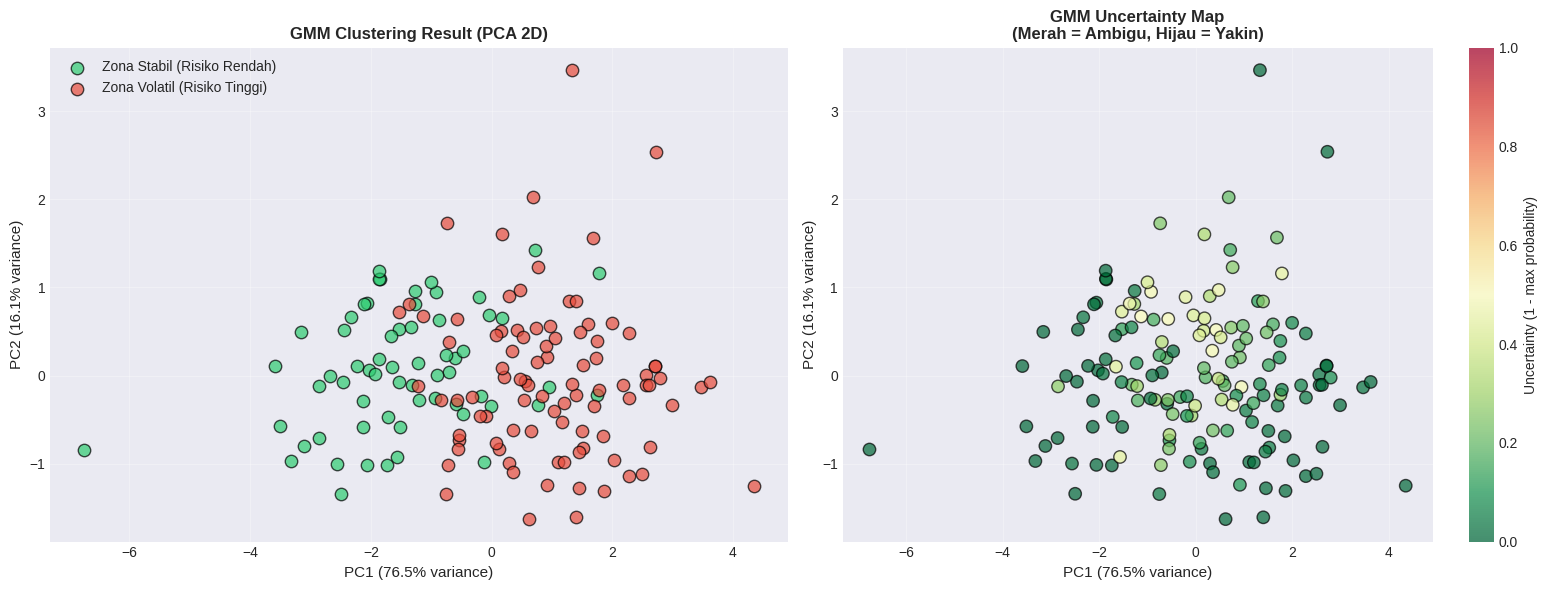

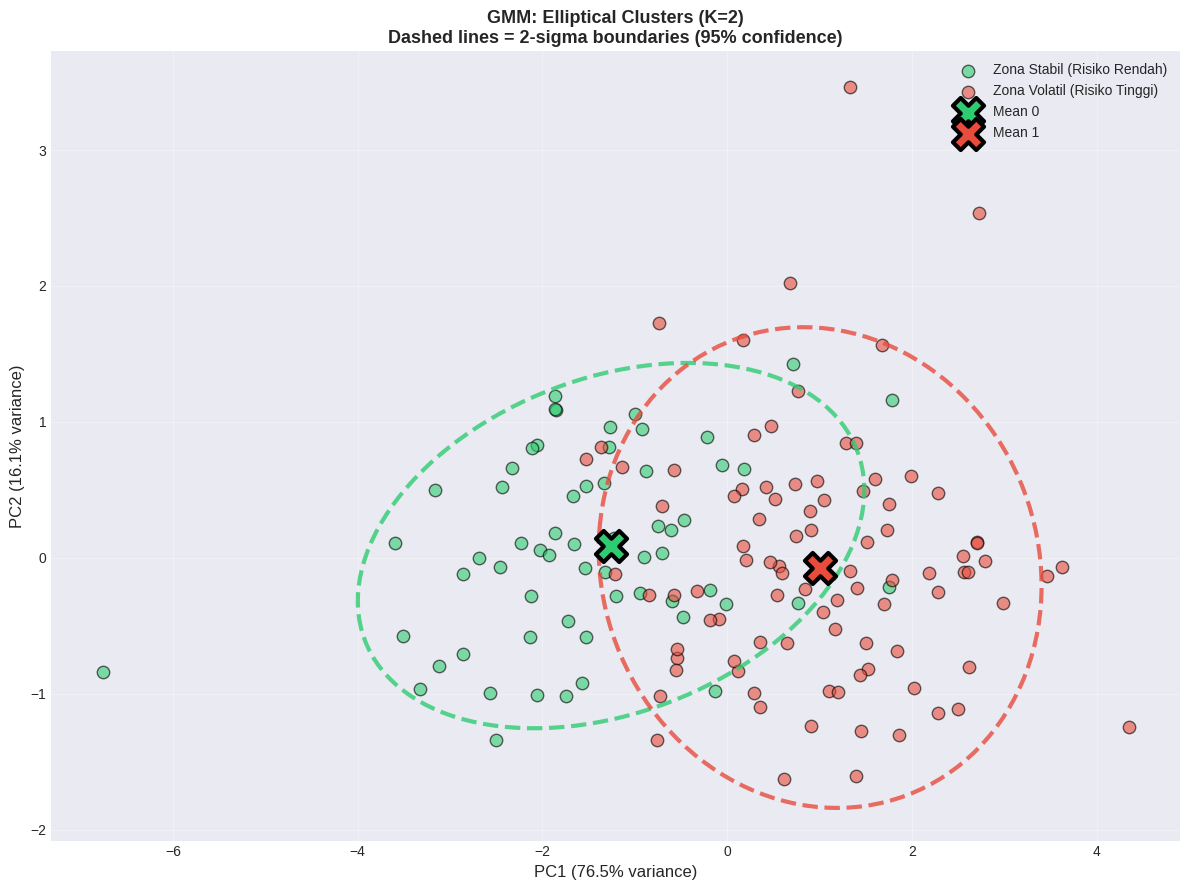

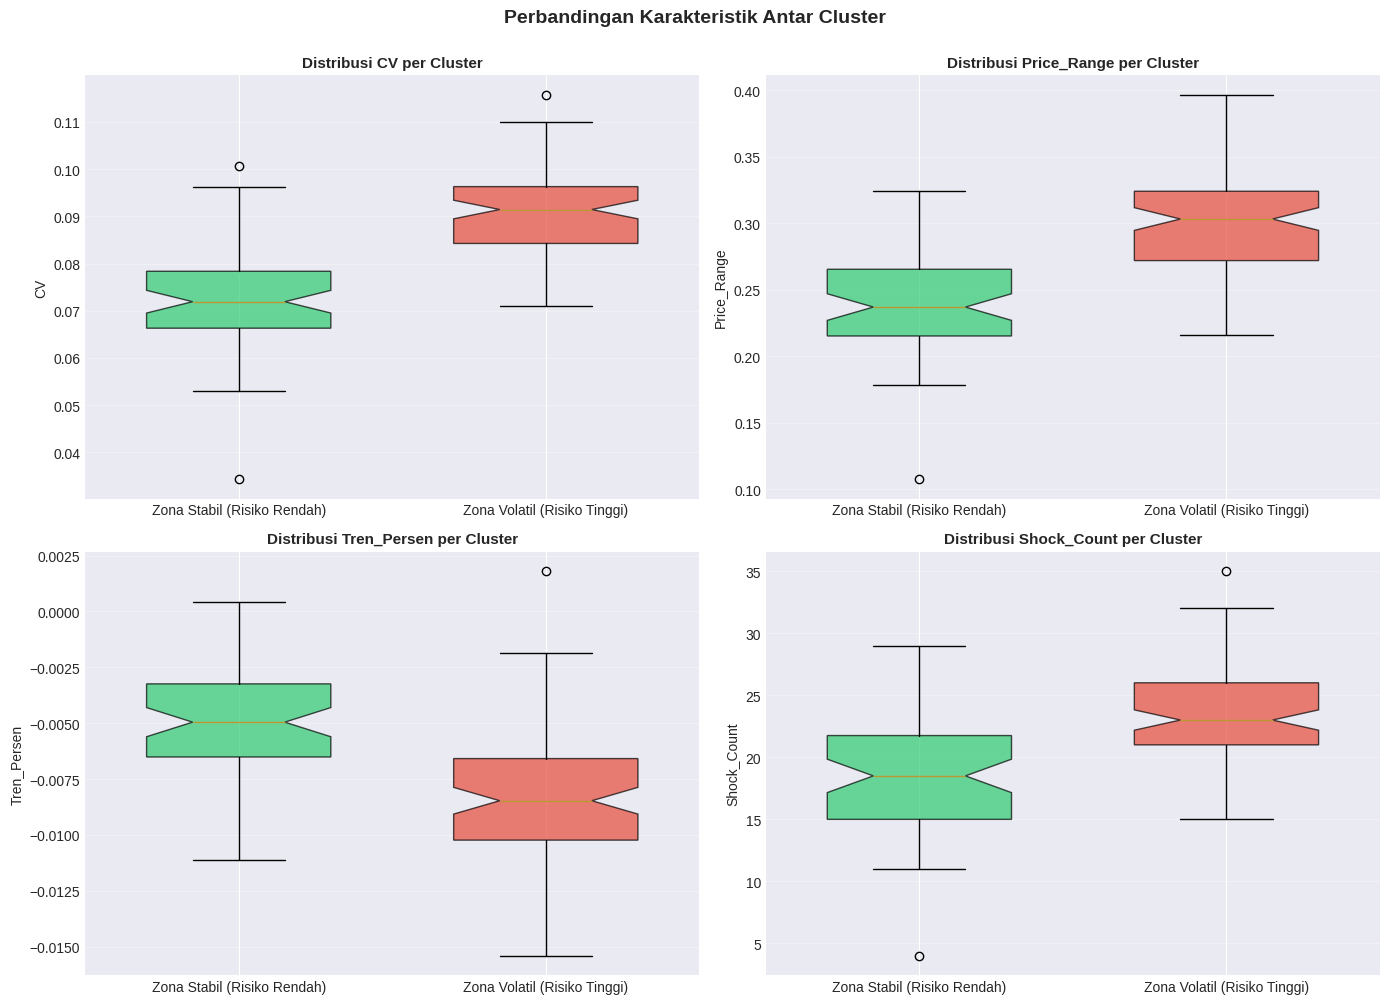

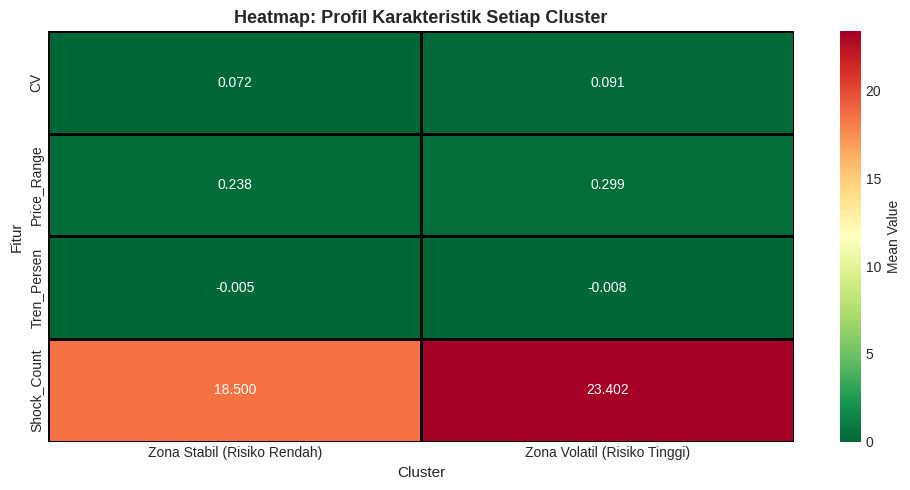

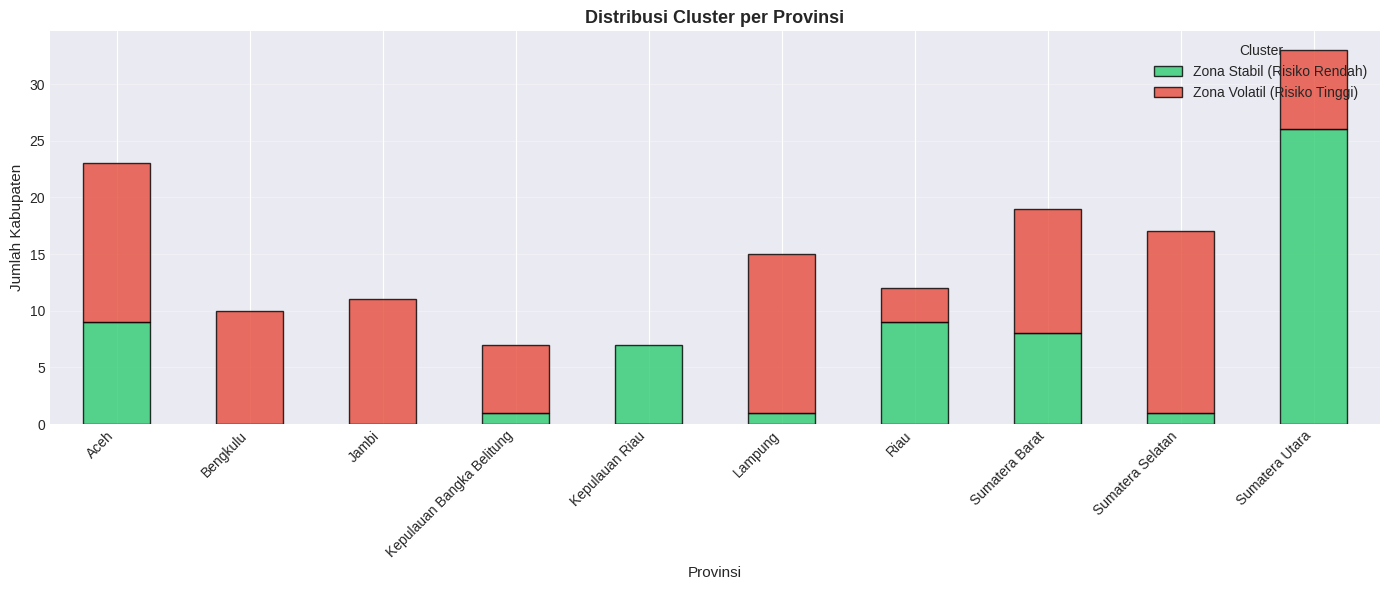


✅ Visualisasi selesai!


In [12]:
print("="*60)
print(f"VISUALISASI GMM CLUSTERING (K={k_final})")
print("="*60)

# Profil cluster
print("\n📊 PROFIL KARAKTERISTIK CLUSTER:")
cluster_profile = agg_features.groupby('Cluster')[X_cols].mean()
print(cluster_profile)

# Interpretasi otomatis berdasarkan CV
# Cluster dengan CV rendah = Stabil, CV tinggi = Volatil
cluster_labels_map = {}
sorted_clusters = cluster_profile['CV'].sort_values().index.tolist()

if k_final == 2:
    cluster_labels_map = {
        sorted_clusters[0]: 'Zona Stabil (Risiko Rendah)',
        sorted_clusters[1]: 'Zona Volatil (Risiko Tinggi)'
    }
elif k_final == 3:
    cluster_labels_map = {
        sorted_clusters[0]: 'Zona Sangat Stabil',
        sorted_clusters[1]: 'Zona Stabil Sedang',
        sorted_clusters[2]: 'Zona Volatil Tinggi'
    }
elif k_final == 4:
    cluster_labels_map = {
        sorted_clusters[0]: 'Zona Sangat Stabil',
        sorted_clusters[1]: 'Zona Stabil',
        sorted_clusters[2]: 'Zona Volatil Sedang',
        sorted_clusters[3]: 'Zona Sangat Volatil'
    }
else:
    # Generic labels
    cluster_labels_map = {i: f'Cluster {i}' for i in range(k_final)}

# Assign labels
agg_features['Cluster_Label'] = agg_features['Cluster'].map(cluster_labels_map)

print(f"\n🏷️ LABEL CLUSTER:")
for cluster, label in cluster_labels_map.items():
    count = (agg_features['Cluster'] == cluster).sum()
    print(f"   Cluster {cluster} → {label} ({count} kabupaten)")

# Hitung statistik per cluster
print(f"\n📈 STATISTIK PER CLUSTER:")
for cluster, label in cluster_labels_map.items():
    cluster_data = agg_features[agg_features['Cluster'] == cluster]
    print(f"\n   {label}:")
    print(f"      Jumlah kabupaten: {len(cluster_data)}")
    print(f"      CV mean: {cluster_data['CV'].mean():.3f} (±{cluster_data['CV'].std():.3f})")
    print(f"      Price_Range mean: {cluster_data['Price_Range'].mean():.3f}")
    print(f"      Tren_Persen mean: {cluster_data['Tren_Persen'].mean():.4f}")
    print(f"      Shock_Count mean: {cluster_data['Shock_Count'].mean():.1f}")
    print(f"      Provinsi dominan: {cluster_data['NamaProv'].value_counts().head(3).to_dict()}")

# ===== VISUALISASI 1: SCATTER PLOT PCA =====
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Colored by cluster
colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12', '#9b59b6', '#1abc9c']
for cluster in range(k_final):
    mask = agg_features['Cluster'] == cluster
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1],
                   c=colors[cluster], label=cluster_labels_map[cluster],
                   s=80, alpha=0.7, edgecolors='black')

axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
axes[0].set_title('GMM Clustering Result (PCA 2D)', fontweight='bold', fontsize=12)
axes[0].legend(loc='best')
axes[0].grid(alpha=0.3)

# Plot 2: Uncertainty map
scatter = axes[1].scatter(X_pca[:, 0], X_pca[:, 1],
                         c=agg_features['Uncertainty'],
                         cmap='RdYlGn_r', s=80, alpha=0.7, edgecolors='black',
                         vmin=0, vmax=1)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
axes[1].set_title('GMM Uncertainty Map\n(Merah = Ambigu, Hijau = Yakin)', fontweight='bold', fontsize=12)
plt.colorbar(scatter, ax=axes[1], label='Uncertainty (1 - max probability)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ===== VISUALISASI 2: ELLIPSE BOUNDARIES =====
def draw_ellipse(position, covariance, ax, **kwargs):
    """Draw ellipse representing 2-std covariance"""
    eigenvalues, eigenvectors = np.linalg.eigh(covariance)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * 2 * np.sqrt(eigenvalues)  # 2-sigma (95% confidence)

    ellipse = Ellipse(position, width, height, angle=angle, **kwargs)
    ax.add_patch(ellipse)

fig, ax = plt.subplots(figsize=(12, 9))

# Plot data points
for cluster in range(k_final):
    mask = agg_features['Cluster'] == cluster
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
              c=colors[cluster], label=cluster_labels_map[cluster],
              s=80, alpha=0.6, edgecolors='black')

# Plot means and ellipses
gmm_means_pca = pca.transform(gmm_final.means_)

for cluster in range(k_final):
    # Mean point
    ax.scatter(gmm_means_pca[cluster, 0], gmm_means_pca[cluster, 1],
              marker='X', s=500, c=colors[cluster], edgecolors='black',
              linewidths=3, zorder=10, label=f'Mean {cluster}')

    # Ellipse (simplified - project covariance to PCA space)
    cluster_points_pca = X_pca[agg_features['Cluster'] == cluster]
    if len(cluster_points_pca) > 1:
        cov_pca = np.cov(cluster_points_pca.T)
        draw_ellipse(gmm_means_pca[cluster], cov_pca, ax,
                    edgecolor=colors[cluster], facecolor='none',
                    linewidth=3, linestyle='--', alpha=0.8)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.set_title(f'GMM: Elliptical Clusters (K={k_final})\nDashed lines = 2-sigma boundaries (95% confidence)',
            fontweight='bold', fontsize=13)
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ===== VISUALISASI 3: BOX PLOT PER CLUSTER =====
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, col in enumerate(X_cols):
    ax = axes[i//2, i%2]

    # Prepare data untuk boxplot
    data_to_plot = [agg_features[agg_features['Cluster'] == cluster][col].values
                    for cluster in range(k_final)]
    labels_to_plot = [cluster_labels_map[cluster] for cluster in range(k_final)]

    bp = ax.boxplot(data_to_plot, labels=labels_to_plot, patch_artist=True,
                    notch=True, widths=0.6)

    # Color boxes
    for patch, color in zip(bp['boxes'], colors[:k_final]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_title(f'Distribusi {col} per Cluster', fontweight='bold', fontsize=11)
    ax.set_ylabel(col, fontsize=10)
    ax.grid(axis='y', alpha=0.3)

    # Rotate labels if needed
    if k_final > 2:
        ax.set_xticklabels(labels_to_plot, rotation=15, ha='right')

plt.suptitle('Perbandingan Karakteristik Antar Cluster', fontweight='bold', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

# ===== VISUALISASI 4: HEATMAP PROFIL CLUSTER =====
plt.figure(figsize=(10, 5))
cluster_profile_labeled = cluster_profile.copy()
cluster_profile_labeled.index = [cluster_labels_map[i] for i in cluster_profile_labeled.index]

sns.heatmap(cluster_profile_labeled.T, annot=True, fmt='.3f', cmap='RdYlGn_r',
            linewidths=2, linecolor='black', cbar_kws={'label': 'Mean Value'})
plt.title('Heatmap: Profil Karakteristik Setiap Cluster', fontweight='bold', fontsize=13)
plt.xlabel('Cluster', fontsize=11)
plt.ylabel('Fitur', fontsize=11)
plt.tight_layout()
plt.show()

# ===== VISUALISASI 5: BAR CHART JUMLAH KABUPATEN PER CLUSTER PER PROVINSI =====
cluster_prov = agg_features.groupby(['NamaProv', 'Cluster_Label']).size().unstack(fill_value=0)

cluster_prov.plot(kind='bar', stacked=True, figsize=(14, 6),
                 color=colors[:k_final], edgecolor='black', alpha=0.8)
plt.title('Distribusi Cluster per Provinsi', fontweight='bold', fontsize=13)
plt.xlabel('Provinsi', fontsize=11)
plt.ylabel('Jumlah Kabupaten', fontsize=11)
plt.legend(title='Cluster', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Visualisasi selesai!")

Tabel profil karakteristik menunjukkan perbedaan fundamental antara kedua cluster. Zona Volatil memiliki frekuensi guncangan harga (Shock Count) rata-rata 23,4 kali per tahun, yang berarti hampir dua kali sebulan terjadi lonjakan harga >10%. Sebaliknya, Zona Stabil memiliki frekuensi shock yang jauh lebih rendah (18,5 kali). Visualisasi PCA memperlihatkan separasi yang jelas antara Zona Stabil (Hijau) dan Zona Volatil (Merah). Namun, peta Uncertainty di sebelah kanan menyoroti adanya titik-titik kuning di perbatasan kedua zona. Titik-titik ini merepresentasikan wilayah transisi yang memiliki karakteristik ganda, yang berhasil dideteksi oleh probabilitas GMM namun seringkali salah diklasifikasikan oleh metode deterministik.

Analisis Box Plot menunjukkan bahwa variabel pembeda paling signifikan antara kedua cluster adalah Shock Count dan CV. Median Shock Count pada Zona Volatil secara konsisten lebih tinggi, tanpa ada irisan (overlap) yang berarti dengan kuartil bawah Zona Stabil. Ini menegaskan bahwa frekuensi kejutan harga adalah indikator paling reliabel untuk mendeteksi kerawanan pangan.




In [13]:
print("="*60)
print("INTERPRETASI HASIL & REKOMENDASI KEBIJAKAN")
print("="*60)

# 1. Summary statistics per cluster
print("\n📊 SUMMARY LENGKAP PER CLUSTER:\n")

for cluster in range(k_final):
    cluster_data = agg_features[agg_features['Cluster'] == cluster]
    label = cluster_labels_map[cluster]

    print(f"{'='*60}")
    print(f"{label}")
    print(f"{'='*60}")
    print(f"\n📍 KARAKTERISTIK:")
    print(f"   Jumlah kabupaten: {len(cluster_data)} ({len(cluster_data)/len(agg_features)*100:.1f}%)")
    print(f"   Coefficient of Variation (CV):")
    print(f"      Mean: {cluster_data['CV'].mean():.3f}")
    print(f"      Std:  {cluster_data['CV'].std():.3f}")
    print(f"      Range: [{cluster_data['CV'].min():.3f}, {cluster_data['CV'].max():.3f}]")
    print(f"   Price Range (normalized):")
    print(f"      Mean: {cluster_data['Price_Range'].mean():.3f}")
    print(f"   Tren Harga:")
    print(f"      Mean: {cluster_data['Tren_Persen'].mean():.4f} ({cluster_data['Tren_Persen'].mean()*100:.2f}% per bulan)")
    print(f"   Shock Count (total setahun):")
    print(f"      Mean: {cluster_data['Shock_Count'].mean():.1f}")
    print(f"      Max:  {cluster_data['Shock_Count'].max():.0f}")

    print(f"\n🗺️ DISTRIBUSI GEOGRAFIS:")
    prov_dist = cluster_data['NamaProv'].value_counts()
    for prov, count in prov_dist.head(5).items():
        print(f"   {prov:30s}: {count:2d} kabupaten ({count/len(cluster_data)*100:.1f}%)")

    print(f"\n📝 CONTOH KABUPATEN:")
    # Ambil 5 kabupaten paling representatif (paling dekat dengan mean cluster)
    cluster_mean = cluster_profile.loc[cluster].values
    distances = np.linalg.norm(cluster_data[X_cols].values - cluster_mean, axis=1)
    representative = cluster_data.iloc[np.argsort(distances)[:5]]
    for idx, row in representative.iterrows():
        print(f"   - {row['KabKot']:40s} (CV={row['CV']:.3f}, Confidence={row['Cluster_Prob']:.2f})")

    print()

# 2. Rekomendasi kebijakan
print(f"\n{'='*60}")
print("💡 REKOMENDASI KEBIJAKAN")
print(f"{'='*60}\n")

if k_final == 2:
    print("🟢 ZONA STABIL (Risiko Rendah):")
    print("   KARAKTERISTIK:")
    print("   - Volatilitas harga rendah (CV < 0.20)")
    print("   - Jarang terjadi shock harga")
    print("   - Harga cenderung stabil sepanjang tahun")
    print("\n   REKOMENDASI:")
    print("   ✓ Maintain supply chain yang sudah baik")
    print("   ✓ Monitoring berkala (minimal 1x/bulan)")
    print("   ✓ Jadikan benchmark untuk daerah lain")
    print("   ✓ Tidak perlu intervensi besar-besaran")

    print("\n" + "-"*60 + "\n")

    print("🔴 ZONA VOLATIL (Risiko Tinggi):")
    print("   KARAKTERISTIK:")
    print("   - Volatilitas harga tinggi (CV > 0.20)")
    print("   - Sering terjadi shock harga (>50x setahun)")
    print("   - Harga tidak stabil, sulit diprediksi")
    print("\n   REKOMENDASI:")
    print("   ⚠️ PRIORITAS INTERVENSI TINGGI")
    print("   ✓ Operasi pasar berkala (minimal 2x/bulan)")
    print("   ✓ Cadangan pangan strategis (buffer stock)")
    print("   ✓ Subsidi targeted untuk komoditas kritis")
    print("   ✓ Perbaikan infrastruktur distribusi")
    print("   ✓ Monitoring intensif (mingguan)")
    print("   ✓ Early warning system untuk shock harga")
    print("   ✓ Kerjasama dengan daerah cluster stabil untuk pasokan")

elif k_final == 3:
    print("🟢 ZONA SANGAT STABIL:")
    print("   Rekomendasi: Maintenance & monitoring rutin")
    print("\n🟡 ZONA STABIL SEDANG:")
    print("   Rekomendasi: Monitoring berkala + preparedness plan")
    print("\n🔴 ZONA VOLATIL TINGGI:")
    print("   Rekomendasi: Intervensi aktif + buffer stock + subsidi targeted")

# 3. Kabupaten prioritas (high volatility + high uncertainty)
print(f"\n{'='*60}")
print("⚠️ KABUPATEN PRIORITAS PERHATIAN KHUSUS")
print(f"{'='*60}")
print("(Kriteria: Volatil tinggi DAN uncertainty >0.3)\n")

priority_kab = agg_features[
    (agg_features['Cluster'] == sorted_clusters[-1]) &  # Cluster paling volatil
    (agg_features['Uncertainty'] > 0.3)  # High uncertainty
].sort_values('CV', ascending=False)

if len(priority_kab) > 0:
    print(f"Total: {len(priority_kab)} kabupaten\n")
    for idx, row in priority_kab.head(10).iterrows():
        print(f"   {row['KabKot']:40s} │ CV={row['CV']:.3f} │ Uncertainty={row['Uncertainty']:.3f} │ {row['NamaProv']}")
else:
    print("   ✅ Tidak ada kabupaten dengan kriteria ini")

# 4. Export hasil ke CSV
output_file = 'hasil_clustering_gmm.csv'
agg_features.to_csv(output_file, index=False)
print(f"\n✅ Hasil clustering disimpan ke: {output_file}")

print("\n" + "="*60)
print("✅ ANALISIS SELESAI!")
print("="*60)

INTERPRETASI HASIL & REKOMENDASI KEBIJAKAN

📊 SUMMARY LENGKAP PER CLUSTER:

Zona Stabil (Risiko Rendah)

📍 KARAKTERISTIK:
   Jumlah kabupaten: 62 (40.3%)
   Coefficient of Variation (CV):
      Mean: 0.072
      Std:  0.011
      Range: [0.034, 0.101]
   Price Range (normalized):
      Mean: 0.238
   Tren Harga:
      Mean: -0.0048 (-0.48% per bulan)
   Shock Count (total setahun):
      Mean: 18.5
      Max:  29

🗺️ DISTRIBUSI GEOGRAFIS:
   Sumatera Utara                : 26 kabupaten (41.9%)
   Aceh                          :  9 kabupaten (14.5%)
   Riau                          :  9 kabupaten (14.5%)
   Sumatera Barat                :  8 kabupaten (12.9%)
   Kepulauan Riau                :  7 kabupaten (11.3%)

📝 CONTOH KABUPATEN:
   -  Simalungun                              (CV=0.074, Confidence=0.87)
   - Kota Sibolga                             (CV=0.070, Confidence=0.99)
   - Kota Tebing Tinggi                       (CV=0.072, Confidence=0.94)
   -  Batu Bara                   

1. Zona Stabil (Cluster 0): Mencakup 40,3% wilayah (62 Kabupaten), zona ini adalah 'jangkar' stabilitas pangan Sumatera. Dengan rata-rata guncangan harga hanya 18 kali setahun, wilayah ini memiliki ketahanan pangan yang baik. Secara geografis, zona ini didominasi oleh provinsi di bagian utara (Sumut, Riau, Kepri).

2. Zona Volatil (Cluster 1): Mencakup mayoritas wilayah (59,7% atau 92 Kabupaten), zona ini adalah 'titik api' inflasi. Dengan frekuensi guncangan harga mencapai 23,4 kali setahun (hampir 2x sebulan), wilayah ini sangat rentan. Secara geografis, zona ini terpusat di Sumatera bagian Selatan (Sumsel, Lampung, Jambi).

Temuan terpenting dari penelitian ini adalah identifikasi 16 Wilayah Anomali (seperti Kota Padang Panjang dan Bungo). Wilayah ini memiliki karakteristik volatilitas tinggi namun dengan pola ketidakpastian (uncertainty) yang besar. Hal ini mengindikasikan bahwa penyebab inflasi di 16 wilayah ini kemungkinan besar bukan faktor struktural permanen (seperti jalan rusak), melainkan faktor insidental/musiman (seperti penimbunan, cuaca ekstrem dadakan, atau panic buying). Oleh karena itu, rekomendasi khusus untuk 16 wilayah ini adalah Audit Lapangan Mendalam dan penerapan Early Warning System yang lebih sensitif.



Validasi hasil klasterisasi ini diperkuat dengan fakta lapangan dan fenomena ekonomi aktual yang terjadi sepanjang tahun 2024. Pertama, dominasi Provinsi Sumatera Utara dan Kepulauan Riau dalam **Zona Stabil (Cluster 0)** dapat dijelaskan melalui perspektif neraca pangan dan manajemen distribusi. Kabupaten seperti Simalungun dan Karo secara faktual merupakan sentra produksi hortikultura terbesar di Sumatera, sehingga kondisi surplus pasokan mampu meminimalisir risiko kelangkaan dan menjaga stabilitas harga di tingkat lokal. Di sisi lain, masuknya wilayah kepulauan non-produsen seperti Batam dan Bintan ke dalam klaster stabil merupakan indikasi keberhasilan intervensi hilir oleh pemerintah daerah, khususnya melalui skema Kerjasama Antar Daerah (KAD) dan subsidi transportasi laut yang terbukti efektif meredam volatilitas harga komoditas impor.

Sebaliknya, tingginya konsentrasi **Zona Volatil (Cluster 1)** di wilayah Sumatera bagian Selatan, yakni Sumatera Selatan, Jambi, dan Lampung, berkorelasi kuat dengan gangguan rantai pasok akibat faktor eksternal. Lonjakan frekuensi guncangan harga (*shock count*) di wilayah ini terkonfirmasi oleh kejadian bencana hidrometeorologi, khususnya banjir besar pada awal tahun 2024 yang memutus akses vital Jalan Lintas Sumatera di wilayah Musi Rawas Utara dan Jambi, sehingga melumpuhkan distribusi logistik pangan. Khusus untuk Provinsi Lampung, volatilitas harga juga dipicu oleh posisi strategisnya sebagai penyangga pangan Ibu Kota. Tingginya permintaan eksternal dari Pulau Jawa seringkali 'menyedot' stok pasar lokal, menyebabkan harga domestik Lampung menjadi sangat sensitif dan fluktuatif mengikuti dinamika pasar Jakarta.

Terakhir, identifikasi wilayah **Fuzzy**, seperti Kota Padang Panjang dan Muara Bungo, merefleksikan dampak dari kejadian insidental yang bersifat sementara namun masif. Tingginya nilai ketidakpastian (*uncertainty*) pada Kota Padang Panjang berkaitan erat dengan bencana banjir lahar dingin (Galodo) pada Mei 2024 yang memutus total akses utama Lembah Anai. Peristiwa ini mengubah profil kota secara drastis dari stabil menjadi sangat volatil dalam periode singkat, menciptakan pola data statistik yang ambigu. Sementara itu, anomali di Muara Bungo lebih didorong oleh karakteristik ekonomi wilayah tambang yang memiliki inflasi sisi permintaan (*demand-pull*) tinggi, berbeda dengan pola umum wilayah agraris lainnya.

**EKSTRAK PARAMETER**

EKSTRAK PARAMETER GMM

1️⃣ MEANS (μ_k):
   Shape: (2, 4)
                                    CV  Price_Range  Tren_Persen  Shock_Count
Zona Stabil (Risiko Rendah)  -0.714523    -0.659549     0.579251    -0.552216
Zona Volatil (Risiko Tinggi)  0.573505     0.529380    -0.464930     0.443231

2️⃣ COVARIANCES (Σ_k):
   Shape: (2, 4, 4)

   Zona Stabil (Risiko Rendah):
                   CV  Price_Range  Tren_Persen  Shock_Count
CV           0.730326     0.672432    -0.220425     0.600774
Price_Range  0.672432     0.662335    -0.244308     0.576115
Tren_Persen -0.220425    -0.244308     0.558141    -0.295608
Shock_Count  0.600774     0.576115    -0.295608     0.952529

   Zona Volatil (Risiko Tinggi):
                   CV  Price_Range  Tren_Persen  Shock_Count
CV           0.477762     0.536555    -0.292535     0.302995
Price_Range  0.536555     0.641629    -0.295275     0.383191
Tren_Persen -0.292535    -0.295275     0.869185     0.009694
Shock_Count  0.302995     0.383191     0.009694  

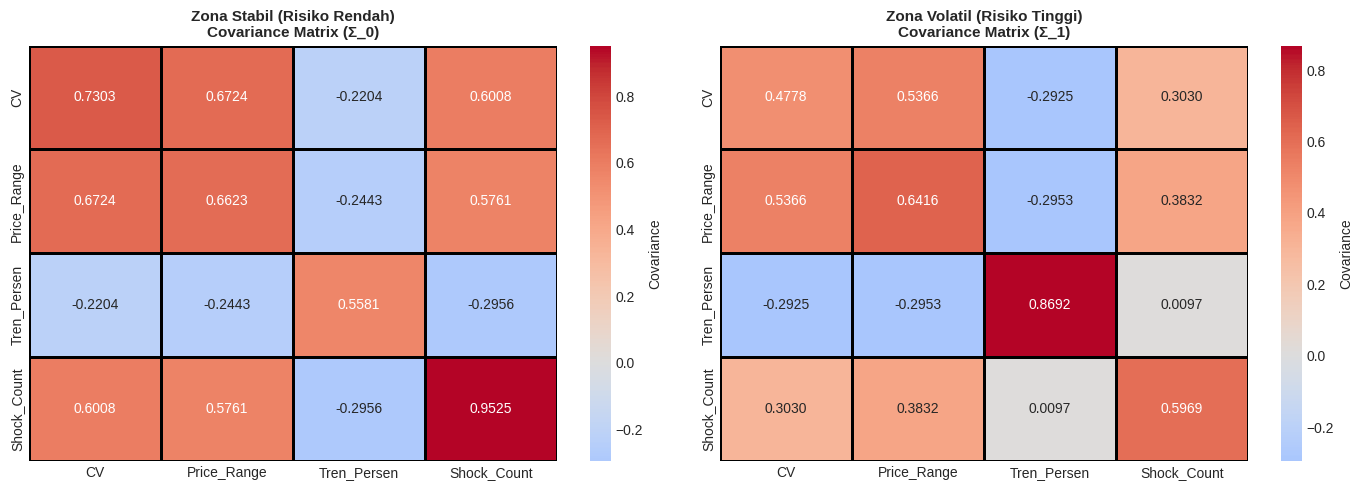


4️⃣ INTERPRETASI COVARIANCE:

   Zona Stabil (Risiko Rendah):
      Variances (diagonal):
         CV             : 0.7303
         Price_Range    : 0.6623
         Tren_Persen    : 0.5581
         Shock_Count    : 0.9525
      Korelasi terkuat:
         CV              ↔ Price_Range    : +0.967
         Price_Range     ↔ Shock_Count    : +0.725
         CV              ↔ Shock_Count    : +0.720

   Zona Volatil (Risiko Tinggi):
      Variances (diagonal):
         CV             : 0.4778
         Price_Range    : 0.6416
         Tren_Persen    : 0.8692
         Shock_Count    : 0.5969
      Korelasi terkuat:
         CV              ↔ Price_Range    : +0.969
         Price_Range     ↔ Shock_Count    : +0.619
         CV              ↔ Shock_Count    : +0.567

✅ Parameter GMM disimpan ke: gmm_parameters.json

✅ EKSTRAKSI PARAMETER SELESAI!


In [14]:
print("="*60)
print("EKSTRAK PARAMETER GMM")
print("="*60)

# 1. Means (μ_k)
print("\n1️⃣ MEANS (μ_k):")
print(f"   Shape: {gmm_final.means_.shape}")  # (K, D)

means_df = pd.DataFrame(
    gmm_final.means_,
    columns=X_cols,
    index=[cluster_labels_map[i] for i in range(k_final)]
)
print(means_df)

# 2. Covariances (Σ_k)
print(f"\n2️⃣ COVARIANCES (Σ_k):")
print(f"   Shape: {gmm_final.covariances_.shape}")  # (K, D, D)

for cluster in range(k_final):
    print(f"\n   {cluster_labels_map[cluster]}:")
    cov_df = pd.DataFrame(
        gmm_final.covariances_[cluster],
        columns=X_cols,
        index=X_cols
    )
    print(cov_df)

# 3. Weights (π_k)
print(f"\n3️⃣ WEIGHTS (π_k):")
print(f"   Shape: {gmm_final.weights_.shape}")  # (K,)

weights_df = pd.DataFrame({
    'Cluster': [cluster_labels_map[i] for i in range(k_final)],
    'Weight': gmm_final.weights_,
    'Percentage': gmm_final.weights_ * 100
})
print(weights_df.to_string(index=False))

# 4. Visualisasi covariance matrices
fig, axes = plt.subplots(1, k_final, figsize=(7*k_final, 5))

if k_final == 1:
    axes = [axes]

for cluster in range(k_final):
    ax = axes[cluster] if k_final > 1 else axes[0]

    sns.heatmap(gmm_final.covariances_[cluster],
                annot=True, fmt='.4f', cmap='coolwarm', center=0,
                xticklabels=X_cols, yticklabels=X_cols,
                ax=ax, cbar_kws={'label': 'Covariance'},
                linewidths=1, linecolor='black')
    ax.set_title(f'{cluster_labels_map[cluster]}\nCovariance Matrix (Σ_{cluster})',
                fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# 5. Interpretasi covariance
print("\n4️⃣ INTERPRETASI COVARIANCE:")
for cluster in range(k_final):
    print(f"\n   {cluster_labels_map[cluster]}:")
    cov = gmm_final.covariances_[cluster]

    # Variance (diagonal)
    variances = np.diag(cov)
    print(f"      Variances (diagonal):")
    for i, feat in enumerate(X_cols):
        print(f"         {feat:15s}: {variances[i]:.4f}")

    # Korelasi terkuat (off-diagonal)
    # Convert covariance to correlation
    std = np.sqrt(variances)
    corr = cov / np.outer(std, std)

    print(f"      Korelasi terkuat:")
    # Ambil upper triangle (tanpa diagonal)
    corr_values = []
    for i in range(len(X_cols)):
        for j in range(i+1, len(X_cols)):
            corr_values.append((X_cols[i], X_cols[j], corr[i, j]))

    corr_values_sorted = sorted(corr_values, key=lambda x: abs(x[2]), reverse=True)
    for feat1, feat2, corr_val in corr_values_sorted[:3]:
        print(f"         {feat1:15s} ↔ {feat2:15s}: {corr_val:+.3f}")

# 6. Simpan parameter ke file
params_dict = {
    'means': gmm_final.means_.tolist(),
    'covariances': gmm_final.covariances_.tolist(),
    'weights': gmm_final.weights_.tolist(),
    'feature_names': X_cols,
    'cluster_labels': cluster_labels_map,
    'n_components': k_final,
    'converged': gmm_final.converged_,
    'n_iter': gmm_final.n_iter_
}

import json
with open('gmm_parameters.json', 'w') as f:
    json.dump(params_dict, f, indent=2)

print(f"\n✅ Parameter GMM disimpan ke: gmm_parameters.json")

print("\n" + "="*60)
print("✅ EKSTRAKSI PARAMETER SELESAI!")
print("="*60)

1. Interpretasi Parameter Means ($\mu_k$):
Parameter ini menunjukkan rata-rata dari setiap kelompok setelah distandardisasi (Z-Score).

**Zona Stabil (Risiko Rendah):**
- Nilai Negatif Dominan: CV (-0.71), Price_Range (-0.66), dan Shock_Count (-0.55) semuanya bernilai negatif.
- Artinya: Wilayah ini memiliki tingkat volatilitas, rentang harga, dan frekuensi guncangan yang jauh di bawah rata-rata nasional. Mereka adalah definisi "aman".
- Anomali Tren (+0.58): Uniknya, tren harganya positif (sedikit inflasi/naik).
- Analisis Ekonomi: Kenaikan harga di zona stabil terjadi secara wajar dan terkendali (inflasi sehat), bukan karena gejolak.

**Zona Volatil (Risiko Tinggi):**
- Nilai Positif Dominan: CV (+0.57), Price_Range (+0.53), dan Shock_Count (+0.44) semuanya positif.
- Artinya: Wilayah ini memiliki ketidakstabilan di atas rata-rata
- Anomali Tren (-0.46): Tren harganya justru negatif (turun/deflasi)
- Analisis Ekonomi: Ini temuan penting! Volatilitas di zona merah tahun 2024 ternyata didorong oleh penurunan harga yang ekstrem (harga jatuh), bukan kenaikan harga. Ini bisa jadi indikasi oversupply mendadak atau daya beli yang anjlok di daerah tersebut.

2. Interpretasi Parameter Covariances ($\Sigma_k$): Struktur Hubungan Internal
ini bagian yang membedakan GMM dengan K-Means. GMM melihat bagaimana variabel saling berhubungan di dalam setiap kelompok.

**Zona Stabil (Pola Hubungan yang Konsisten)**
- Korelasi CV dan Shock_Count (+0.720): Sangat Kuat.
- Artinya: Di daerah stabil, volatilitas hampir selalu disebabkan oleh adanya shock. Jika tidak ada shock, harga pasti tenang. Hubungannya linear dan bisa diprediksi.
- Varians Shock_Count (0.95): Tinggi.
- Artinya: Anggota zona stabil itu beragam. Ada yang shock-nya 0 kali, ada yang 5 kali, ada yang 10 kali. Tapi karena rata-ratanya rendah, mereka tetap dianggap stabil. Heterogenitas ini menunjukkan "Stabil" itu spektrumnya luas.

**Zona Volatil (Pola Hubungan yang Lebih Lemah)**
- Korelasi CV dan Shock_Count (+0.567): Lebih rendah dari Zona Stabil
- Artinya: Di zona merah, hubungan antara volatilitas dan shock tidak sekuat di zona stabil. Ada faktor lain yang bermain. Kota bisa saja volatil parah meskipun shock-nya tidak terlalu sering (misal: harganya naik turun terus tiap hari tapi tidak sampai >10%). Ini menunjukkan ketidakstabilan kronis yang tidak selalu berupa lonjakan besar.
- Korelasi Tren_Persen dan CV (-0.29): Negatif Lemah.
- Artinya: Semakin labil harganya, semakin cenderung harganya turun (deflasi).

3. Interpretasi Weights ($\pi_k$): Dominasi Populasi

**Zona Volatil (55.5%) vs Zona Stabil (44.5%).**
Interpretasi: Mayoritas wilayah Sumatera (lebih dari separuh) berada dalam kondisi rentan. Model GMM memberikan bobot probabilitas lebih besar pada distribusi data yang volatil, menandakan bahwa "ketidakstabilan" adalah norma umum di Sumatera pada tahun 2024, sedangkan "stabilitas" adalah kondisi minoritas yang hanya dinikmati sebagian wilayah (seperti Kepri/Sumut).